##### *Name: Berkay Koçak*

##### *Student ID: 614468*

##### *E-mail: kocakberkayy@gmail.com*

# ADVANCED DATA ANALYTICS FOR MANAGEMENT SUPPORT - ASSIGNMENT

## Table of Contents

    1. Introduction
    2. Data Preperation & Exploratory Data Analysis
        2.1. Text Features
        2.2. Host Features
        2.3. Property Features
        2.4. Location Features
        2.5. Review Features
    3. Model Structure
        3.1. Data Preperation
            3.1.1. Non-text Columns
            3.1.2. Text Columns
        3.2. Benchmark Models
            3.2.1. Random Forest Regressor
            3.2.2. Extreme Gradient Regressor
            3.2.3. Support Vector Regressor
            3.2.4. GRU
        3.3. RNN Structure
            3.3.1. LSTM
            3.3.2. Bidirectional LSTM
            3.3.3. Stacked LSTM   
        3.4. Complete Model
    4. Application to Test Data
    5. Conclusions

## 1. Introduction

Airbnb is a platform which meets the hosts and guests to expand on housing possibilities. While the hosts are using the application to rent their own properties to number of guests of their choice, the platform offers a variety of housing options for guests looking for a place to stay. The company which has experienced an unprecedented growth in the past decades also has a massive interest in the analysis of the generated data. The dataset that is used in this project comes from AirBnb listings.

The aim of this assignment is to predict the rental price per night of AirBnb listings while making use of a wide range of NLP techniques. The data includes both textual and tabular formats. Therefore, one of the main parts of this assignment is to build a NN based model structure that can incorporate both data types. 

In the following sections, first the data preparation and the exploratory data analysis for the features are handled. Then, a model structure is defined. For this reason, several benchmark models and RNN structures are tried and a composite model is developed. Finally, the model is applied to the test data to come up with predictions.

In [1]:
#Standard Libraries
import numpy  as np 
import pandas as pd
import time
from IPython import display

# Libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Library re provides regular expressions functionality
import re

# Saving and loaded objects
import pickle

# Library beatifulsoup4 handles html
from bs4 import BeautifulSoup

# Standard NLP workflow
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import textstat
from collections import Counter
from nltk.tokenize import sent_tokenize

# For data preperation before modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.preprocessing import MinMaxScaler

# For target encoding
#pip install category_encoders
import category_encoders as ce

# Benchmark Models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math # for sqrt
from sklearn.model_selection import cross_val_score
from statistics import mean

# GENSIM and LSTM models
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, concatenate, Dense, Embedding, LSTM, GRU, Bidirectional, BatchNormalization, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras import activations, losses

In [2]:
# In order to show every column when analysing the data
pd.set_option('display.max_columns', None)

In [3]:
# Reading the train and the test data
train = pd.read_csv("C:/Users/Berkay Kocak/Desktop/ADAMS/ASSIGNMENT_DATA/train.csv")
test  = pd.read_csv('C:/Users/Berkay Kocak/Desktop/ADAMS/ASSIGNMENT_DATA/test.csv')
reviews = pd.read_csv("C:/Users/Berkay Kocak/Desktop/ADAMS/ASSIGNMENT_DATA/reviews.csv")
print(train.shape, test.shape)

(55284, 42) (29769, 41)


## 2. Data Preparation & Exploratory Data Analysis

In this section, data preparation and exploratory data analysis for the features are carried out simultaneously. Moreover, when it seemed to be necessary and helpful for the models, new features are also engineered in this part.

The "summary" feature is excluded from the dataset since the content is already included in the "description" column for the majority of instances one of which is shown below. "Space" is also outside the scope of this project since it also gives repetitive information that other columns such as "bedrooms", "beds" and "amenities" contain. In addition, "house_rules" attribute is also disregarded since the rules of the house are not a strong determinant of the price of a house. The "neighbourhood_cleansed" column is used while the "neighbourhood" column is disregarded. Finally, the "picture_url" feature is also eliminated since the related data will not be used for this project.

In [4]:
print('\033[1m'+"The summary column provides:"+'\033[0m'+"\n")
print(train.summary.iloc[21])
print("\n")
print('\033[1m'+"The description column provides:"+'\033[0m' "\n")
print(train.description.iloc[21])

The summary column provides:

Nice private room available for up to 3 people in a 4 Bedroom apartment. Great location, only 3 Mins walk from Shadwell Station. We provide fresh bed linen and towels Please note you will be sharing the kitchen and bathroom with other guests. Feel free to book.


The description column provides:

Nice private room available for up to 3 people in a 4 Bedroom apartment. Great location, only 3 Mins walk from Shadwell Station. We provide fresh bed linen and towels Please note you will be sharing the kitchen and bathroom with other guests. Feel free to book. Room comes with comfortable bunk bed ( double bottom/single top) , bedside table with lamp, wardrobe, big windows with lots of light, carpet. Kitchen is fully fitted with everything you need (fridge-freezer, cooker with 4 burners, oven, microwave, kettle, toaster, cutlery, plates, glasses, mugs, pots, pans etc.…) We provide tea, coffee and sugar There is a bathroom with toilet. There is key box set up next 

In [5]:
print('\033[1m'+"The space column provides:"+'\033[0m'+"\n")
print(train.space.iloc[21])
print("\n")
print('\033[1m'+"The amenities column provides:"+'\033[0m' "\n")
print(train.amenities.iloc[21])

The space column provides:

Room comes with comfortable bunk bed ( double bottom/single top) , bedside table with lamp, wardrobe, big windows with lots of light, carpet. Kitchen is fully fitted with everything you need (fridge-freezer, cooker with 4 burners, oven, microwave, kettle, toaster, cutlery, plates, glasses, mugs, pots, pans etc.…) We provide tea, coffee and sugar There is a bathroom with toilet.


The amenities column provides:

{Wifi,Kitchen,Heating,Washer,Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hot water","Bed linens",Microwave,Refrigerator,"Dishes and silverware","Cooking basics",Oven,Stove}


In [6]:
# Dropping unnecessary columns
train.drop(["summary","picture_url","space","house_rules","neighbourhood"], inplace=True, axis=1)

In [7]:
# Dropping unnecessary columns
test.drop(["summary","picture_url","space","house_rules","neighbourhood"], inplace=True, axis=1)

In [8]:
# Partitioning the data into subgroups for analysis. They will be analysed in detail in the next section.
text_features=["name","description","neighborhood_overview","transit","amenities"]

host_features = ["host_id", "host_since", "host_response_time", "host_response_rate","host_is_superhost", 
                  "host_total_listings_count","host_has_profile_pic", "host_identity_verified"]

property_features = ["experiences_offered","property_type","room_type", "accommodates", "bathrooms", "bedrooms",
       "beds", "bed_type","guests_included","cancellation_policy"]

review_features = ["review_scores_rating", "review_scores_accuracy","review_scores_cleanliness", "review_scores_checkin",
       "review_scores_communication", "review_scores_location","review_scores_value", "reviews_per_month"]

location_features = ["neighbourhood_cleansed", "outward_code","latitude","longitude"]

##### Note:

From this point on every change that is made on the train dataset is also applied to test dataset in each sub-section for ease of following and interpretation. Applications on test set will not be elaborated additionally unless it is necassary.

### 2.1. Text Features

Missing values in the text features are replaced with an empty string. This way the embeddings of the related observations will be vectors consisting of 0s which will have the most desired effect on the deep learning algorithms that will be employed in this assignment. 

In [9]:
train[text_features].isna().sum()

name                        14
description               1726
neighborhood_overview    19506
transit                  19807
amenities                    0
dtype: int64

In [10]:
# "NA" values are changed with an empty text.
train.name.fillna("",inplace=True)
train.description.fillna("",inplace=True)
train.neighborhood_overview.fillna("",inplace=True)
train.transit.fillna("",inplace=True)

In [11]:
train[text_features].isna().sum()

name                     0
description              0
neighborhood_overview    0
transit                  0
amenities                0
dtype: int64

In [12]:
# "NA" values are changed with an empty text.
test.name.fillna("",inplace=True)
test.description.fillna("",inplace=True)
test.neighborhood_overview.fillna("",inplace=True)
test.transit.fillna("",inplace=True)

In [13]:
train.amenities.head(n=5)

0    {Wifi,"Paid parking off premises",Heating,Wash...
1    {TV,Wifi,"Free parking on premises",Breakfast,...
2    {Wifi,Kitchen,"Paid parking off premises",Heat...
3    {TV,Wifi,Kitchen,Heating,Washer,"Smoke detecto...
4    {TV,Wifi,Kitchen,"Paid parking off premises",H...
Name: amenities, dtype: object

As can be seen above, "amenities" column has several unwanted non alpha-numeric characters that needs to be handled. To this purpose, a new function clean_alt_list is defined. The purpose of the function is to replace the characters with empty strings.

In [14]:
# Function for cleaning the columns amenities and response rate.
def clean_alt_list(list_):
    list_ = list_.replace('"', '')
    list_ = list_.replace('{', '')
    list_ = list_.replace('}', '}')
    list_ = list_.replace("%","")
    list_ = list_.replace(',', ' ')
    return list_

The new version of the amenities can be seen below. The unwanted characters are handled and the column is ready to be tokenized after some further cleaning that is introduced below.

In [15]:
# Non alpha-numeric characters are removed from the amenities column
amenities_edited = train.amenities.apply(clean_alt_list)
amenities_edited

0        Wifi Paid parking off premises Heating Washer ...
1        TV Wifi Free parking on premises Breakfast Fre...
2        Wifi Kitchen Paid parking off premises Heating...
3        TV Wifi Kitchen Heating Washer Smoke detector ...
4        TV Wifi Kitchen Paid parking off premises Heat...
                               ...                        
55279    TV Cable TV Wifi Wheelchair accessible Kitchen...
55280    TV Wifi Kitchen Heating Smoke detector Fire ex...
55281    TV Cable TV Wifi Kitchen Free parking on premi...
55282    Wifi Kitchen Paid parking off premises Elevato...
55283    TV Wifi Paid parking off premises Pets allowed...
Name: amenities, Length: 55284, dtype: object

In [16]:
# Non alpha-numeric characters are removed from the amenities column
amenities_edited_test = test.amenities.apply(clean_alt_list)

In [17]:
# Lemmatize with POS Tag
def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [18]:
def clean_reviews(df):
    """ Standard NLP pre-processing chain including removal of html tags, non-alphanumeric characters, and stopwords.
        Words are subject to lemmatization using their POS tags, which are determind using WordNet. 
    """
    reviews = []

    lemmatizer = WordNetLemmatizer()
    
    print('*' * 40)
    print('Cleaning {} rows.'.format(df.shape[0]))
    counter = 0
    for name in df:
        
        # remove html content
        review_text = BeautifulSoup(name).get_text()
        
        # remove newlines
        review_text = review_text.replace("\n", " ")
        review_text = review_text.replace("\xa0", " ")
        
        # remove URLs
        review_text = re.sub(r'http\S+', '', review_text)
        review_text = re.sub(r'www\.\S+', '', review_text)
        
        # remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        
        # fix contractions
        review_text = re.sub(r"['’]ll", " will", review_text)
        review_text = re.sub(r"['’]ve", " have", review_text)
        review_text = re.sub(r"['’]re", " are", review_text)
        review_text = re.sub(r"['’]d", " would", review_text)
        review_text = re.sub(r"['’]m", " am", review_text)
        review_text = re.sub(r"(?i)there['’]s", "there is", review_text)
        review_text = re.sub(r"(?i)that['’]s", "that is", review_text)
        review_text = re.sub(r"(?i)it['’]s", "it is", review_text)
        review_text = re.sub(r"(?i)he['’]s", "he is", review_text)
        review_text = re.sub(r"can['’]t", "cannot", review_text)
        review_text = re.sub(r"won['’]t", "will not", review_text)
        review_text = re.sub(r"n['’]t", " not", review_text)
        review_text = review_text.replace("gonna", "going to")
        review_text = review_text.replace("wanna", "want to")
        review_text = review_text.replace("gotta", "got to")
    
        # tokenize the sentences
        words = word_tokenize(review_text.lower())
  
        # filter stopwords
        words = [w for w in words if w not in stopwords.words("english")]
        
        # lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    
        reviews.append(lemma_words)
              
        if (counter > 0 and counter % 10000 == 0):
            print('Processed {} columns'.format(counter))
            
        counter += 1
        
    print('DONE')
    print('*' * 40)

    return(reviews)

Now, the data is ready for text cleaning. The functions that are defined above are deployed for cleaning the texts. The steps for cleaning the text data include removing any possible html content, removing non-alphabetic characters, fixing contractions, tokenizing the sentences filtering the stopwords and lemmatizing. 

In [115]:
start = time.time()
train_name_clean=clean_reviews(train.name)
end = time.time()
print(f"Cleaned names column in {end - start} seconds.")

****************************************
Cleaning 55284 movie reviews.
Processed 10000 reviews
Processed 20000 reviews
Processed 30000 reviews
Processed 40000 reviews
Processed 50000 reviews
DONE
****************************************
Cleaned names column in 641.2753252983093 seconds.


In [341]:
start = time.time()
train_amenities_clean=clean_reviews(amenities_edited)
end = time.time()
print(f"Cleaned amenities column in {end - start} seconds.")

****************************************
Cleaning 55284 rows.
Processed 10000 columns
Processed 20000 columns
Processed 30000 columns
Processed 40000 columns
Processed 50000 columns
DONE
****************************************
Cleaned names column in 3932.4807801246643 seconds.


In [120]:
start = time.time()
train_description_clean=clean_reviews(train.description)
end = time.time()
print(f"Cleaned description column in {end - start} seconds.")

****************************************
Cleaning 55284 movie reviews.
Processed 10000 reviews
Processed 20000 reviews
Processed 30000 reviews
Processed 40000 reviews
Processed 50000 reviews


C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


DONE
****************************************
Cleaned names column in 10643.700334787369 seconds.


In [121]:
start = time.time()
train_neighborhood_overview_clean=clean_reviews(train.neighborhood_overview)
end = time.time()
print(f"Cleaned neighbourhood column in {end - start} seconds.")

****************************************
Cleaning 55284 movie reviews.
Processed 10000 reviews
Processed 20000 reviews
Processed 30000 reviews


C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://ru.airbnb.com/things-to-do/london" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 40000 reviews
Processed 50000 reviews
DONE
****************************************
Cleaned neighbourhood column in 3458.544822692871 seconds.


In [122]:
start = time.time()
train_transit_clean=clean_reviews(train.transit)
end = time.time()
print(f"Cleaned transit column in {end - start} seconds.")

****************************************
Cleaning 55284 movie reviews.


C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'......'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Processed 10000 reviews
Processed 20000 reviews
Processed 30000 reviews
Processed 40000 reviews


C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://www.airbnb.co.uk/things-to-do/london" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Processed 50000 reviews
DONE
****************************************
Cleaned transit column in 2632.4617989063263 seconds.


In [342]:
start = time.time()
test_name_clean=clean_reviews(test.name)
end = time.time()
print(f"Cleaned names column in {end - start} seconds.")

****************************************
Cleaning 29769 rows.
Processed 10000 columns


C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\bs4\__init__.py:336: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Processed 20000 columns
DONE
****************************************
Cleaned names column in 349.4753751754761 seconds.


In [343]:
start = time.time()
test_amenities_clean=clean_reviews(amenities_edited_test)
end = time.time()
print(f"Cleaned amenities column in {end - start} seconds.")

****************************************
Cleaning 29769 rows.
Processed 10000 columns
Processed 20000 columns
DONE
****************************************
Cleaned names column in 2097.2218840122223 seconds.


In [344]:
start = time.time()
test_description_clean=clean_reviews(test.description)
end = time.time()
print(f"Cleaned description column in {end - start} seconds.")

****************************************
Cleaning 29769 rows.


C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\bs4\__init__.py:336: MarkupResemblesLocatorWarning: ".." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Processed 10000 columns


C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\bs4\__init__.py:336: MarkupResemblesLocatorWarning: ". . ." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Processed 20000 columns
DONE
****************************************
Cleaned description column in 5353.478093147278 seconds.


In [345]:
start = time.time()
test_neighborhood_overview_clean=clean_reviews(test.neighborhood_overview)
end = time.time()
print(f"Cleaned neighbourhood column in {end - start} seconds.")

****************************************
Cleaning 29769 rows.


C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\bs4\__init__.py:424: MarkupResemblesLocatorWarning: "https://www.airbnb.com/locations/london/shoreditch" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\bs4\__init__.py:336: MarkupResemblesLocatorWarning: ".........." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Processed 10000 columns
Processed 20000 columns
DONE
****************************************
Cleaned neighbourhood column in 1790.5071024894714 seconds.


In [346]:
start = time.time()
test_transit_clean=clean_reviews(test.transit)
end = time.time()
print(f"Cleaned transit column in {end - start} seconds.")

****************************************
Cleaning 29769 rows.


C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\bs4\__init__.py:336: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Processed 10000 columns
Processed 20000 columns
DONE
****************************************
Cleaned transit column in 1430.7341828346252 seconds.


Since the procedure takes a fairly high amount of time the outputs of the text cleaning operation are saved to the disc in order to be used in the following steps without repetition. 

In [123]:
# Writing the clean text columns of train data to disc.
with open('train_name_clean.pkl', 'wb') as file_name:
    pickle.dump(train_name_clean, file_name)
with open('train_description_clean.pkl', 'wb') as file_name:
    pickle.dump(train_description_clean, file_name)
with open('train_neighborhood_overview_clean.pkl', 'wb') as file_name:
    pickle.dump(train_neighborhood_overview_clean, file_name)
with open('train_transit_clean.pkl', 'wb') as file_name:
    pickle.dump(train_transit_clean, file_name)
with open('train_amenities_clean.pkl', 'wb') as file_name:
    pickle.dump(train_amenities_clean, file_name)

In [348]:
# Writing the clean text columns of test data to disc.
with open('test_name_clean.pkl', 'wb') as file_name:
    pickle.dump(test_name_clean, file_name)
with open('test_description_clean.pkl', 'wb') as file_name:
    pickle.dump(test_description_clean, file_name)
with open('test_neighborhood_overview_clean.pkl', 'wb') as file_name:
    pickle.dump(test_neighborhood_overview_clean, file_name)
with open('test_transit_clean.pkl', 'wb') as file_name:
    pickle.dump(test_transit_clean, file_name)
with open('test_amenities_clean.pkl', 'wb') as file_name:
    pickle.dump(test_amenities_clean, file_name)

In [19]:
# Reading the clean text columns of train data from disc.
with open('train_name_clean.pkl', 'rb') as file_name:
    train["name_clean"] = pickle.load(file_name)

with open('train_description_clean.pkl', 'rb') as file_name:
    train["description_clean"] = pickle.load(file_name)

with open('train_neighborhood_overview_clean.pkl', 'rb') as file_name:
    train["neighborhood_overview_clean"] = pickle.load(file_name)
    
with open('train_transit_clean.pkl', 'rb') as file_name:
    train["transit_clean"] = pickle.load(file_name)
    
with open('train_amenities_clean.pkl', 'rb') as file_name:
    train["amenities_clean"] = pickle.load(file_name)

In [20]:
# Reading the clean text columns of test data from disc.
with open('test_name_clean.pkl', 'rb') as file_name:
    test["name_clean"] = pickle.load(file_name)

with open('test_description_clean.pkl', 'rb') as file_name:
    test["description_clean"] = pickle.load(file_name)

with open('test_neighborhood_overview_clean.pkl', 'rb') as file_name:
    test["neighborhood_overview_clean"] = pickle.load(file_name)
    
with open('test_transit_clean.pkl', 'rb') as file_name:
    test["transit_clean"] = pickle.load(file_name)
    
with open('test_amenities_clean.pkl', 'rb') as file_name:
    test["amenities_clean"] = pickle.load(file_name)

The raw text columns before the cleaning operation are no longer needed. Therefore, the related columns are dropped.

In [21]:
# Dropping the unclean text columns
train.drop(["name","description","neighborhood_overview","transit","amenities"], inplace=True, axis=1)

In [22]:
# Dropping the unclean text columns
test.drop(["name","description","neighborhood_overview","transit","amenities"], inplace=True, axis=1)

### 2.2. Host Features

#### Host Response Rate

The host response rates are in a format that is yet not usable by the algorithms. In order to properly format them, first they are turned into strings and the percentage at the end is cleaned. Afterwards, they are set as basic float values. The distribution plot of the values show that they are highly skewed. Moreover, nearly 30% of the data has missing values. Therefore, it makes sense to discretize the data and fill the "NA" values with a new category level "Missing".

In [23]:
train.host_response_rate.head()

0    100%
1    100%
2    100%
3    100%
4    100%
Name: host_response_rate, dtype: object

In [24]:
# Removing the % from end and setting the data type as float.
train["host_response_rate"] = train["host_response_rate"].astype(str)
train.host_response_rate = train.host_response_rate.apply(clean_alt_list)
train["host_response_rate"] = train["host_response_rate"].astype(float)

In [25]:
# Removing the % from end and setting the data type as float.
test["host_response_rate"] = test["host_response_rate"].astype(str)
test.host_response_rate = test.host_response_rate.apply(clean_alt_list)
test["host_response_rate"] = test["host_response_rate"].astype(float)

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


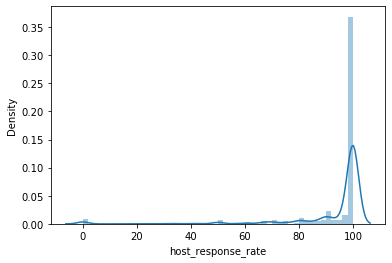

In [26]:
# Checking the distribution of host response rate column.
sns.distplot(train['host_response_rate'])

In [27]:
# Checking the number of "NA" observations.
train['host_response_rate'].isna().sum()

17802

In [28]:
# Discretization of the column host response rate
train["host_response_rate_cat"]=train.host_response_rate.fillna("Missing")
train.loc[(train["host_response_rate"]>=0),"host_response_rate_cat"]="0-50"
train.loc[(train["host_response_rate"]>=50),"host_response_rate_cat"]="50-70"
train.loc[(train["host_response_rate"]>=70),"host_response_rate_cat"]="70-90"
train.loc[(train["host_response_rate"]>=90),"host_response_rate_cat"]="90-100"

In [29]:
# Discretization of the column host response rate
test["host_response_rate_cat"]=test.host_response_rate.fillna("Missing")
test.loc[(test["host_response_rate"]>=0),"host_response_rate_cat"]="0-50"
test.loc[(test["host_response_rate"]>=50),"host_response_rate_cat"]="50-70"
test.loc[(test["host_response_rate"]>=70),"host_response_rate_cat"]="70-90"
test.loc[(test["host_response_rate"]>=90),"host_response_rate_cat"]="90-100"

In [30]:
# The host respones rate column is eliminated
train.drop(["host_response_rate"], inplace=True, axis=1)

# Setting the datatype as category
train["host_response_rate_cat"] = train['host_response_rate_cat'].astype('category')

In [31]:
# The host respones rate column is eliminated
test.drop(["host_response_rate"], inplace=True, axis=1)

# Setting the datatype as category
test["host_response_rate_cat"] = test['host_response_rate_cat'].astype('category')

#### Host Total Listings Count

Similar steps are followed for also "host_total_listings_count" feature. 

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


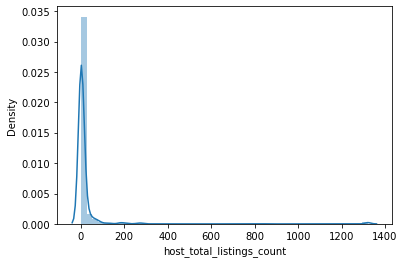

In [32]:
# Checking the distribution of host total listings count column.
sns.distplot(train['host_total_listings_count'])

In [33]:
# Checking the number of "NA" observations.
train['host_total_listings_count'].isna().sum()

111

In [34]:
# Discretizing the continuous variable host total listing count
train["host_total_listings_count_cat"]=train.host_total_listings_count.fillna("Missing")
train.loc[(train["host_total_listings_count"]==0),"host_total_listings_count_cat"]="0"
train.loc[(train["host_total_listings_count"]==1),"host_total_listings_count_cat"]="1"
train.loc[(train["host_total_listings_count"]>=2),"host_total_listings_count_cat"]="2-5"
train.loc[(train["host_total_listings_count"]>=6),"host_total_listings_count_cat"]="6-10"
train.loc[(train["host_total_listings_count"]>=11),"host_total_listings_count_cat"]="10+"

In [35]:
# Discretizing the continuous variable host total listing count
test["host_total_listings_count_cat"]=test.host_total_listings_count.fillna("Missing")
test.loc[(test["host_total_listings_count"]==0),"host_total_listings_count_cat"]="0"
test.loc[(test["host_total_listings_count"]==1),"host_total_listings_count_cat"]="1"
test.loc[(test["host_total_listings_count"]>=2),"host_total_listings_count_cat"]="2-5"
test.loc[(test["host_total_listings_count"]>=6),"host_total_listings_count_cat"]="6-10"
test.loc[(test["host_total_listings_count"]>=11),"host_total_listings_count_cat"]="10+"

In [36]:
# Host total listings count column is eliminated
train.drop(["host_total_listings_count"], inplace=True, axis=1)

# Setting the data type as category
train["host_total_listings_count_cat"] = train['host_total_listings_count_cat'].astype('category')

In [37]:
# Host total listings count column is eliminated
test.drop(["host_total_listings_count"], inplace=True, axis=1)

# Setting the data type as category
test["host_total_listings_count_cat"] = test['host_total_listings_count_cat'].astype('category')

#### Host Response Time

For the host response time feature, the "NA" values are filled with a new category level "Missing". The data type is set as category since it only has 4 different levels for response time.

In [38]:
# Checking the unique values of host response time.
train["host_response_time"].unique()

array(['within an hour', 'within a few hours', nan, 'within a day',
       'a few days or more'], dtype=object)

In [39]:
# Checking the number of "NA" observations.
train['host_response_time'].isna().sum()

17802

In [40]:
# Filling the "NA" values with new category level "missing"
train.host_response_time.fillna("Missing",inplace=True)

# Setting the data type as category
train["host_response_time"] = train['host_response_time'].astype('category')

In [41]:
# Filling the "NA" values with new category level "missing"
test.host_response_time.fillna("Missing",inplace=True)

# Setting the data type as category
test["host_response_time"] = test['host_response_time'].astype('category')

#### Host Since

The current format of the feature "host_since" is not usable by the algorithms. Therefore, instead of a date, a new feature is engineered which is the duration of hosting since the registration. The new feature is calculated via substracting the subscription date from the most current date in the dataset. Lastly, "NA" values are replaced with the median of the column. In order to decrease repetition in the following sections, the last operation is handled by a function which will be used also for other numerical columns.

In [42]:
train.host_since.head()

0    2012-04-18
1    2014-05-29
2    2019-06-28
3    2012-08-24
4    2016-09-09
Name: host_since, dtype: object

In [43]:
train.host_since.isna().sum()

111

In [44]:
# Function for replacing "NA" values with median for numerical columns.
def replace_na_median(column):
    median=column.median(skipna=True)
    column.fillna(median,inplace=True)

In [45]:
# Setting the datatype as date time
train['host_since'] = pd.to_datetime(train['host_since'])

# Calculation of the duration of hosting since registration
train["host_for_days"]=(max(train["host_since"])-train["host_since"]).dt.days

# Replacing "NA" values with the median
replace_na_median(train.host_for_days)

# Dropping the host_since column
train.drop(["host_since"], inplace=True, axis=1)

In [46]:
# Setting the data type as date time
test['host_since'] = pd.to_datetime(test['host_since'])

# Calculation of the duration of hosting since registration
test["host_for_days"]=(max(test["host_since"])-test["host_since"]).dt.days

# Replacing "NA" values with the median
replace_na_median(test.host_for_days)

# Dropping the host_since column
test.drop(["host_since"], inplace=True, axis=1)

In [47]:
train.host_for_days.head()

0    2821.0
1    2050.0
2     194.0
3    2693.0
4    1216.0
Name: host_for_days, dtype: float64

In [48]:
train.host_for_days.isna().sum()

0

For the boolean variables that can be seen in the following parts, the "t" and "f" values are mapped into 1 and 0's and the missing values are filled with the majority class. Finally, datatypes are set as boolean.

#### Host is Superhost

In [49]:
train.host_is_superhost.value_counts()

f    46982
t     8191
Name: host_is_superhost, dtype: int64

In [50]:
train.host_is_superhost.isna().sum()

111

In [51]:
# t and f mapped into 1 and 0
train.host_is_superhost=train.host_is_superhost.map(dict(t=1, f=0))

# Since the majority of instances are false fill "NA" values with 0.
train.host_is_superhost.fillna(0,inplace=True)

# Data type is set as boolean
train["host_is_superhost"] = train['host_is_superhost'].astype('bool')

In [52]:
# t and f mapped into 1 and 0
test.host_is_superhost=test.host_is_superhost.map(dict(t=1, f=0))

# Since the majority of instances in train set are false fill "NA" values with 0.
test.host_is_superhost.fillna(0,inplace=True)

# Data type is set as boolean
test["host_is_superhost"] = test['host_is_superhost'].astype('bool')

In [53]:
train.host_is_superhost.value_counts()

False    47093
True      8191
Name: host_is_superhost, dtype: int64

In [54]:
train.host_is_superhost.isna().sum()

0

#### Host has Profile Picture

In [55]:
train.host_has_profile_pic.value_counts()

t    55013
f      160
Name: host_has_profile_pic, dtype: int64

In [56]:
train.host_has_profile_pic.isna().sum()

111

In [57]:
# t and f mapped into 1 and 0
train.host_has_profile_pic=train.host_has_profile_pic.map(dict(t=1, f=0))

# Since the majority of instances are true fill "NA" values with 1.
train.host_has_profile_pic.fillna(1,inplace=True)

# Data type is set as boolean
train["host_has_profile_pic"] = train['host_has_profile_pic'].astype('bool')

In [58]:
# t and f mapped into 1 and 0
test.host_has_profile_pic=test.host_has_profile_pic.map(dict(t=1, f=0))

# Since the majority of instances in train set are true fill "NA" values with 1.
test.host_has_profile_pic.fillna(1,inplace=True)

# Data type is set as boolean
test["host_has_profile_pic"] = test['host_has_profile_pic'].astype('bool')

In [59]:
train.host_has_profile_pic.value_counts()

True     55124
False      160
Name: host_has_profile_pic, dtype: int64

In [60]:
train.host_has_profile_pic.isna().sum()

0

#### Host Identity Verified

In [61]:
train.host_identity_verified.value_counts()

f    35346
t    19827
Name: host_identity_verified, dtype: int64

In [62]:
train.host_identity_verified.isna().sum()

111

In [63]:
# t and f mapped into 1 and 0
train.host_identity_verified=train.host_identity_verified.map(dict(t=1, f=0))

# Since the majority of instances are false fill "NA" values with 0.
train.host_identity_verified.fillna(0,inplace=True)

# Data type is set as boolean
train["host_identity_verified"] = train['host_identity_verified'].astype('bool')

In [64]:
# t and f mapped into 1 and 0
test.host_identity_verified=test.host_identity_verified.map(dict(t=1, f=0))

# Since the majority of instances in train set are false fill "NA" values with 0.
test.host_identity_verified.fillna(0,inplace=True)

# Data type is set as boolean
test["host_identity_verified"] = test['host_identity_verified'].astype('bool')

In [65]:
train.host_identity_verified.value_counts()

False    35457
True     19827
Name: host_identity_verified, dtype: int64

In [66]:
train.host_identity_verified.isna().sum()

0

### 2.3. Property Features

The missing values in the property features are replaced with the median value of the related column. Since the amount of missing data is small proportional to whole dataset this choice is not very significant. The datatypes of the columns are set properly afterwards.

In [67]:
train[property_features].isna().sum()

experiences_offered      0
property_type            0
room_type                0
accommodates             0
bathrooms               70
bedrooms                62
beds                   262
bed_type                 0
guests_included          0
cancellation_policy      0
dtype: int64

In [68]:
# "NA" values in the property features are replaced with median.
replace_na_median(train.bathrooms)
replace_na_median(train.bedrooms)
replace_na_median(train.beds)

In [69]:
# "NA" values in the property features are replaced with median.
replace_na_median(test.bathrooms)
replace_na_median(test.bedrooms)
replace_na_median(test.beds)

In [70]:
train[property_features].dtypes

experiences_offered     object
property_type           object
room_type               object
accommodates             int64
bathrooms              float64
bedrooms               float64
beds                   float64
bed_type                object
guests_included          int64
cancellation_policy     object
dtype: object

In [71]:
#The data types are set accordingly
train["experiences_offered"] = train['experiences_offered'].astype('category')
train["property_type"] = train['property_type'].astype('category')
train["room_type"] = train['room_type'].astype('category')
train["bed_type"] = train['bed_type'].astype('category')
train["cancellation_policy"] = train['cancellation_policy'].astype('category')

In [72]:
#The data types are set accordingly
test["experiences_offered"] = test['experiences_offered'].astype('category')
test["property_type"] = test['property_type'].astype('category')
test["room_type"] = test['room_type'].astype('category')
test["bed_type"] = test['bed_type'].astype('category')
test["cancellation_policy"] = test['cancellation_policy'].astype('category')

In [73]:
train[property_features].isna().sum()

experiences_offered    0
property_type          0
room_type              0
accommodates           0
bathrooms              0
bedrooms               0
beds                   0
bed_type               0
guests_included        0
cancellation_policy    0
dtype: int64

In [74]:
train[property_features].dtypes

experiences_offered    category
property_type          category
room_type              category
accommodates              int64
bathrooms               float64
bedrooms                float64
beds                    float64
bed_type               category
guests_included           int64
cancellation_policy    category
dtype: object

### 2.4. Location Features

#### Zip Code

The UK zip code format is explained in detail in the picture below.(https://ideal-postcodes.co.uk/guides/uk-postcode-format) Since current zip codes are not very efficient to use for this project due to high number of category levels, outward codes of the zip codes are taken into account and the inward codes are dropped. The outward code shows which area, district and subdistrict the address belongs.

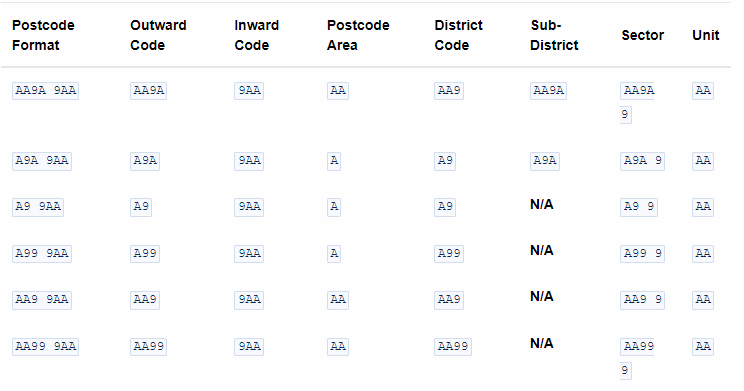

In [75]:
display.Image("C:/Users/Berkay Kocak/Desktop/uk_postcode.png")

In [76]:
len(train.zipcode.unique())

26557

26557 unique values for zipcodes is an enormous number for a categorical variable.

In [77]:
# Zipcode is split into two columns that are named as outward_code and inward_code
train[['outward_code', 'inward_code']] = train['zipcode'].str.split(' ', 1, expand=True)

In [78]:
# Zipcode is split into two columns that are named as outward_code and inward_code
test[['outward_code', 'inward_code']] = test['zipcode'].str.split(' ', 1, expand=True)

If the outward codes are analysed now, one can see that there are still imporper rows that have code length greater than 4. Since it can not be determined exactly from where these codes can be seperated due to the structure of zipcodes, it is a better choice to give these rows a new category name which is "Improper".

In [79]:
# Checking columns where outward code length is greater then 4
train[train.outward_code.apply(lambda x: len(str(x))>4)]

,experiences_offered,host_id,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id,name_clean,description_clean,neighborhood_overview_clean,transit_clean,amenities_clean,host_response_rate_cat,host_total_listings_count_cat,host_for_days,outward_code,inward_code
79,none,224866971,within an hour,False,True,False,Westminster,SW1Y4UF,51.50827,-0.13249,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,170.0,2,98.0,10.0,10.0,10.0,9.0,10.0,9.0,strict_14_with_grace_period,0.99,DF23XM87VC,"[sonder, jermyn, street, playful, br]","[feature, new, york, time, wall, street, journ...","[indulge, graceful, georgian, style, house, ga...",[],"[tv, cable, tv, wifi, kitchen, elevator, heati...",90-100,10+,426.0,SW1Y4UF,None
114,none,36033142,Missing,False,True,False,Lambeth,SW90FA,51.47123,-0.11505,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,150.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,04G6FSRYZ7,"[perfect, london, apartment, holiday]","[new, one, bedroom, apartment, th, floor, stun...",[],[],"[wifi, wheelchair, accessible, kitchen, doorma...",Missing,1,1666.0,SW90FA,None
195,none,5057442,Missing,False,True,True,Hackney,N160JD,51.56200,-0.08045,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,90.0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,0.12,J0SOWM6LEH,"[sunny, stoke, newington, flat, balcony]","[enjoy, well, decorate, sunny, peaceful, one, ...","[stoke, newington, everything, could, ask, fla...","[transport, link, good, plenty, bus, main, str...","[tv, cable, tv, wifi, kitchen, free, street, p...",Missing,1,2521.0,N160JD,None
242,none,224866971,within an hour,False,True,False,Westminster,SW1P3NQ,51.49773,-0.12753,Apartment,Entire home/apt,6,3.5,3.0,3.0,Real Bed,367.0,6,94.0,9.0,9.0,10.0,10.0,10.0,9.0,strict_14_with_grace_period,1.31,MPM3T86FP9,"[sonder, art, council, sleek, br, terrace]","[feature, new, york, time, wall, street, journ...","[home, london, remarkable, historic, attractio...",[],"[tv, cable, tv, wifi, kitchen, elevator, heati...",90-100,10+,426.0,SW1P3NQ,None
247,none,1941593,within an hour,False,True,True,Hammersmith and Fulham,W129SW,51.50273,-0.24019,House,Private room,1,1.0,1.0,1.0,Real Bed,35.0,1,93.0,10.0,10.0,10.0,10.0,9.0,9.0,moderate,1.51,T25TAESKF2,"[single, room]","[beautiful, single, bed, double, room, family,...",[],[],"[internet, wifi, pet, live, property, cat, hea...",90-100,2-5,2853.0,W129SW,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54844,none,180951330,within an hour,True,True,False,Islington,N11PX,51.54334,-0.10434,Apartment,Entire home/apt,6,1.0,2.0,3.0,Real Bed,140.0,1,97.0,10.0,9.0,10.0,10.0,10.0,10.0,flexible,1.18,SK4BTIX82C,"[amaze, flat, amaze, location]","[high, spec, designer, apartment, central, isl...",[],[],"[tv, cable, tv, wifi, kitchen, buzzer, wireles...",50-70,1,652.0,N11PX,None
55156,none,97739713,within an hour,True,True,False,Brent,HA98EH,51.55971,-0.28804,House,Private room,2,1.0,1.0,1.0,Real Bed,50.0,2,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,1.59,6N1YS0CK1N,"[double, room, wembley, park, hse, nr, wembley...","[house, close, wembley, stadium, wembley, aren...","[house, five, minute, walk, wembley, stadium, ...","[wembley, park, station, metropolitan, jubilee...","[internet, wifi, heating, family, kid, friendl...",90-100,1,1192.0,HA98EH,None
55186,none,46715363,within an hour,True,True,True,Barnet,N32PL,51.60509,-0.18628,House,Private room,1,1.0,1.0,1.0,Real Bed,25.0,1,97.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,2.89,A1OZLQFOG1,"[comfortable, double, bedroom]","[lo

In [80]:
# If outward code length is greater then 4 assign it to a category level "improper"
train.loc[(train.outward_code.apply(lambda x: len(str(x))>4)),"outward_code"]="Improper"

# Inward code and the zipcode columns are dropped
train.drop(["inward_code","zipcode"], inplace=True, axis=1)

# Fill "NA" values of outward code with the category level "missing"
train["outward_code"]=train.outward_code.fillna("Missing")

In [81]:
# If outward code length is greater then 4 assign it to a category level "improper"
test.loc[(test.outward_code.apply(lambda x: len(str(x))>4)),"outward_code"]="Improper"

# Inward code and the zipcode columns are dropped
test.drop(["inward_code","zipcode"], inplace=True, axis=1)

# Fill "NA" values of outward code with the category level "missing"
test["outward_code"]=test.outward_code.fillna("Missing")

In [82]:
train.outward_code.unique()

array(['SE10', 'N8', 'SW19', 'SW4', 'SE11', 'SE8', 'W5', 'E1', 'UB3',
       'SW8', 'N7', 'SE22', 'SE24', 'SW3', 'NW6', 'N4', 'SW2', 'SE15',
       'SW1V', 'WC1N', 'SE1', 'N5', 'SE26', 'SE13', 'SE5', 'E2', 'E17',
       'W1W', 'E15', 'E8', 'WC1H', 'Missing', 'N1', 'SW5', 'W6', 'TW7',
       'W10', 'NW1', 'RM7', 'W1T', 'E16', 'N16', 'KT2', 'NW11', 'SE17',
       'NW4', 'W12', 'E14', 'E5', 'TW14', 'SE7', 'W2', 'W7', 'HA0', 'W4',
       'Improper', 'N11', 'E7', 'NW8', 'WC1X', 'W9', 'NW2', 'SE25', 'SW9',
       'SW20', 'SW15', 'SW11', 'TW3', 'SW1X', 'SW1P', 'SE3', 'EC1Y',
       'W1D', 'SE14', 'SW17', 'EN3', 'NW9', 'E4', 'KT9', 'N6', 'WC2N',
       'E1W', 'W14', 'SW18', 'TW9', 'SM6', 'EC1V', 'UB8', 'N15', 'W11',
       'HA2', 'N3', 'E20', 'IG11', 'SE16', 'E3', 'SW6', 'UB5', 'W8',
       'EN2', 'HA4', 'BR1', 'HA1', 'NW3', 'W37', 'CR0', 'SE18', 'SE6',
       'W1G', 'SE27', 'W1H', 'N19', 'NW5', 'WC1V', 'SW10', 'NW10', 'UB7',
       'N2', 'W3', 'SW7', 'E11', 'Wc1x', 'SE12', 'E10', 'WC2H', 'SM5

There is one more issue to handle before the outward_code is usable by the algorithms. The letters should be turned to upper case so that there would not be distinct categories for the same values. 

In [83]:
# Turn all letters into uppercase.
train['outward_code'] = train['outward_code'].str.upper()

In [84]:
# Far better!
len(train.outward_code.unique())

315

In [85]:
# The datatype of the outward code is set as category
train["outward_code"] = train['outward_code'].astype('category')

In [86]:
# Turn all letters into uppercase.
test['outward_code'] = test['outward_code'].str.upper()

# The datatype of the outward code is set as category
test["outward_code"] = test['outward_code'].astype('category')

#### Neighbourhood Cleansed

In [87]:
# The datatype of the neighbourhood cleansed is set as category
train["neighbourhood_cleansed"] = train['neighbourhood_cleansed'].astype('category')

In [88]:
# The datatype of the neighbourhood cleansed is set as category
test["neighbourhood_cleansed"] = test['neighbourhood_cleansed'].astype('category')

### 2.5. Review Features

As can be noticed from the graphs and the table below, there are two main problems regarding the data. First, the data is highly skewed. Secondly, nearly 20% of the data has "Na" values. Both of the problems can be solved by discretizing the data and filling the missing values by a new category level "Missing". When discretizing the variables, the number of observations in the related bins and logical assumptions about the threshold values are taken into account.

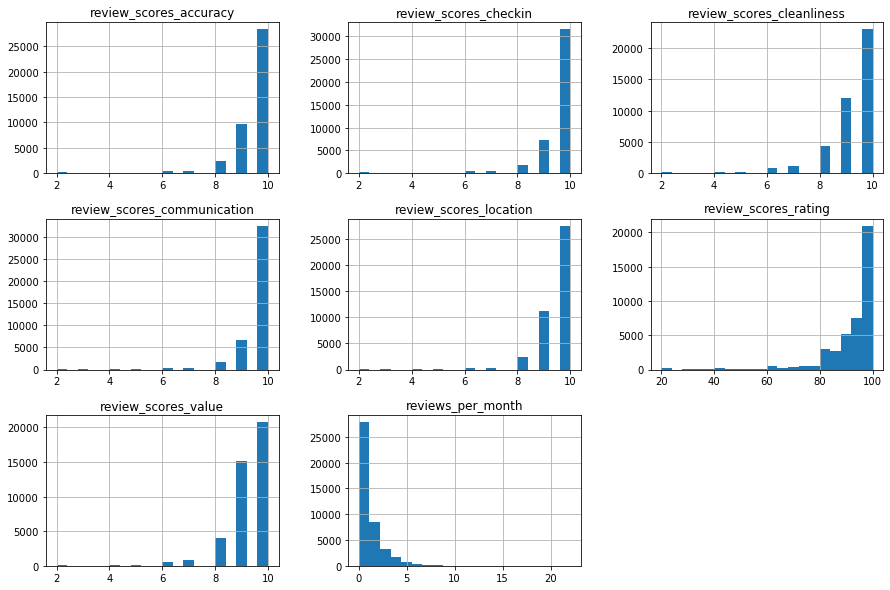

In [89]:
train[review_features].hist(bins=20,figsize=(15, 10));

In [90]:
train[review_features].isna().sum()

review_scores_rating           13415
review_scores_accuracy         13448
review_scores_cleanliness      13442
review_scores_checkin          13483
review_scores_communication    13446
review_scores_location         13480
review_scores_value            13480
reviews_per_month              12380
dtype: int64

In [91]:
#Discretizing the continuous variable review scores communication
train["review_scores_communication_cat"]=train.review_scores_communication.fillna("Missing")
train.loc[(train["review_scores_communication"]==10),"review_scores_communication_cat"]="10"
train.loc[(train["review_scores_communication"]==9),"review_scores_communication_cat"]="9"
train.loc[(train["review_scores_communication"]==8),"review_scores_communication_cat"]="8"
train.loc[(train["review_scores_communication"]<8),"review_scores_communication_cat"]="8-"

In [92]:
#Discretizing the continuous variable review scores communication
test["review_scores_communication_cat"]=test.review_scores_communication.fillna("Missing")
test.loc[(test["review_scores_communication"]==10),"review_scores_communication_cat"]="10"
test.loc[(test["review_scores_communication"]==9),"review_scores_communication_cat"]="9"
test.loc[(test["review_scores_communication"]==8),"review_scores_communication_cat"]="8"
test.loc[(test["review_scores_communication"]<8),"review_scores_communication_cat"]="8-"

In [93]:
#Discretizing the continuous variable review scores accuracy
train["review_scores_accuracy_cat"]=train.review_scores_accuracy.fillna("Missing")
train.loc[(train["review_scores_accuracy"]==10),"review_scores_accuracy_cat"]="10"
train.loc[(train["review_scores_accuracy"]==9),"review_scores_accuracy_cat"]="9"
train.loc[(train["review_scores_accuracy"]==8),"review_scores_accuracy_cat"]="8"
train.loc[(train["review_scores_accuracy"]<8),"review_scores_accuracy_cat"]="8-"

In [94]:
#Discretizing the continuous variable review scores accuracy
test["review_scores_accuracy_cat"]=test.review_scores_accuracy.fillna("Missing")
test.loc[(test["review_scores_accuracy"]==10),"review_scores_accuracy_cat"]="10"
test.loc[(test["review_scores_accuracy"]==9),"review_scores_accuracy_cat"]="9"
test.loc[(test["review_scores_accuracy"]==8),"review_scores_accuracy_cat"]="8"
test.loc[(test["review_scores_accuracy"]<8),"review_scores_accuracy_cat"]="8-"

In [95]:
#Discretizing the continuous variable review scores cleanliness
train["review_scores_cleanliness_cat"]=train.review_scores_cleanliness.fillna("Missing")
train.loc[(train["review_scores_cleanliness"]==10),"review_scores_cleanliness_cat"]="10"
train.loc[(train["review_scores_cleanliness"]==9),"review_scores_cleanliness_cat"]="9"
train.loc[(train["review_scores_cleanliness"]==8),"review_scores_cleanliness_cat"]="8"
train.loc[(train["review_scores_cleanliness"]<8),"review_scores_cleanliness_cat"]="8-"

In [96]:
#Discretizing the continuous variable review scores cleanliness
test["review_scores_cleanliness_cat"]=test.review_scores_cleanliness.fillna("Missing")
test.loc[(test["review_scores_cleanliness"]==10),"review_scores_cleanliness_cat"]="10"
test.loc[(test["review_scores_cleanliness"]==9),"review_scores_cleanliness_cat"]="9"
test.loc[(test["review_scores_cleanliness"]==8),"review_scores_cleanliness_cat"]="8"
test.loc[(test["review_scores_cleanliness"]<8),"review_scores_cleanliness_cat"]="8-"

In [97]:
#Discretizing the continuous variable review scores checkin
train["review_scores_checkin_cat"]=train.review_scores_checkin.fillna("Missing")
train.loc[(train["review_scores_checkin"]==10),"review_scores_checkin_cat"]="10"
train.loc[(train["review_scores_checkin"]==9),"review_scores_checkin_cat"]="9"
train.loc[(train["review_scores_checkin"]==8),"review_scores_checkin_cat"]="8"
train.loc[(train["review_scores_checkin"]<8),"review_scores_checkin_cat"]="8-"

In [98]:
#Discretizing the continuous variable review scores checkin
test["review_scores_checkin_cat"]=test.review_scores_checkin.fillna("Missing")
test.loc[(test["review_scores_checkin"]==10),"review_scores_checkin_cat"]="10"
test.loc[(test["review_scores_checkin"]==9),"review_scores_checkin_cat"]="9"
test.loc[(test["review_scores_checkin"]==8),"review_scores_checkin_cat"]="8"
test.loc[(test["review_scores_checkin"]<8),"review_scores_checkin_cat"]="8-"

In [99]:
#Discretizing the continuous variable review scores location
train["review_scores_location_cat"]=train.review_scores_location.fillna("Missing")
train.loc[(train["review_scores_location"]==10),"review_scores_location_cat"]="10"
train.loc[(train["review_scores_location"]==9),"review_scores_location_cat"]="9"
train.loc[(train["review_scores_location"]==8),"review_scores_location_cat"]="8"
train.loc[(train["review_scores_location"]<8),"review_scores_location_cat"]="8-"

In [100]:
#Discretizing the continuous variable review scores location
test["review_scores_location_cat"]=test.review_scores_location.fillna("Missing")
test.loc[(test["review_scores_location"]==10),"review_scores_location_cat"]="10"
test.loc[(test["review_scores_location"]==9),"review_scores_location_cat"]="9"
test.loc[(test["review_scores_location"]==8),"review_scores_location_cat"]="8"
test.loc[(test["review_scores_location"]<8),"review_scores_location_cat"]="8-"

In [101]:
#Discretizing the continuous variable review scores value
train["review_scores_value_cat"]=train.review_scores_value.fillna("Missing")
train.loc[(train["review_scores_value"]==10),"review_scores_value_cat"]="10"
train.loc[(train["review_scores_value"]==9),"review_scores_value_cat"]="9"
train.loc[(train["review_scores_value"]==8),"review_scores_value_cat"]="8"
train.loc[(train["review_scores_value"]<8),"review_scores_value_cat"]="8-"

In [102]:
#Discretizing the continuous variable review scores value
test["review_scores_value_cat"]=test.review_scores_value.fillna("Missing")
test.loc[(test["review_scores_value"]==10),"review_scores_value_cat"]="10"
test.loc[(test["review_scores_value"]==9),"review_scores_value_cat"]="9"
test.loc[(test["review_scores_value"]==8),"review_scores_value_cat"]="8"
test.loc[(test["review_scores_value"]<8),"review_scores_value_cat"]="8-"

In [103]:
#Discretizing the continuous variable review scores rating
train["review_scores_rating_cat"]=train.review_scores_rating.fillna("Missing")
train.loc[(train["review_scores_rating"]<80),"review_scores_rating_cat"]="80-"
train.loc[(train["review_scores_rating"]>=80),"review_scores_rating_cat"]="80-90"
train.loc[(train["review_scores_rating"]>=90),"review_scores_rating_cat"]="90-95"
train.loc[(train["review_scores_rating"]>=95),"review_scores_rating_cat"]="95-100"
train.loc[(train["review_scores_rating"]==100),"review_scores_rating_cat"]="100"

In [104]:
#Discretizing the continuous variable review scores rating
test["review_scores_rating_cat"]=test.review_scores_rating.fillna("Missing")
test.loc[(test["review_scores_rating"]<80),"review_scores_rating_cat"]="80-"
test.loc[(test["review_scores_rating"]>=80),"review_scores_rating_cat"]="80-90"
test.loc[(test["review_scores_rating"]>=90),"review_scores_rating_cat"]="90-95"
test.loc[(test["review_scores_rating"]>=95),"review_scores_rating_cat"]="95-100"
test.loc[(test["review_scores_rating"]==100),"review_scores_rating_cat"]="100"

In [105]:
#Discretizing the continuous variable reviews per month
train["reviews_per_month_cat"]=train.reviews_per_month.fillna("Missing")
train.loc[(train["reviews_per_month"]<1),"reviews_per_month_cat"]="0-1"
train.loc[(train["reviews_per_month"]>=1),"reviews_per_month_cat"]="1-3"
train.loc[(train["reviews_per_month"]>=3),"reviews_per_month_cat"]="3-5"
train.loc[(train["reviews_per_month"]>5),"reviews_per_month_cat"]="5+"

In [106]:
#Discretizing the continuous variable reviews per month
test["reviews_per_month_cat"]=test.reviews_per_month.fillna("Missing")
test.loc[(test["reviews_per_month"]<1),"reviews_per_month_cat"]="0-1"
test.loc[(test["reviews_per_month"]>=1),"reviews_per_month_cat"]="1-3"
test.loc[(test["reviews_per_month"]>=3),"reviews_per_month_cat"]="3-5"
test.loc[(test["reviews_per_month"]>5),"reviews_per_month_cat"]="5+"

In [107]:
#Dropping the raw columns since they are no longer needed
train.drop(["review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication"
           ,"review_scores_location","review_scores_value","review_scores_rating","reviews_per_month"], inplace=True, axis=1)

In [108]:
#Dropping the raw columns since they are no longer needed
test.drop(["review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication"
           ,"review_scores_location","review_scores_value","review_scores_rating","reviews_per_month"], inplace=True, axis=1)

In [109]:
#Setting the data types as category
train["review_scores_communication_cat"] = train['review_scores_communication_cat'].astype('category')
train["review_scores_accuracy_cat"] = train['review_scores_accuracy_cat'].astype('category')
train["review_scores_cleanliness_cat"] = train['review_scores_cleanliness_cat'].astype('category')
train["review_scores_checkin_cat"] = train['review_scores_checkin_cat'].astype('category')
train["review_scores_location_cat"] = train['review_scores_location_cat'].astype('category')
train["review_scores_value_cat"] = train['review_scores_value_cat'].astype('category')
train["review_scores_rating_cat"] = train['review_scores_rating_cat'].astype('category')
train["reviews_per_month_cat"] = train['reviews_per_month_cat'].astype('category')

In [110]:
#Setting the data types as category
test["review_scores_communication_cat"] = test['review_scores_communication_cat'].astype('category')
test["review_scores_accuracy_cat"] = test['review_scores_accuracy_cat'].astype('category')
test["review_scores_cleanliness_cat"] = test['review_scores_cleanliness_cat'].astype('category')
test["review_scores_checkin_cat"] = test['review_scores_checkin_cat'].astype('category')
test["review_scores_location_cat"] = test['review_scores_location_cat'].astype('category')
test["review_scores_value_cat"] = test['review_scores_value_cat'].astype('category')
test["review_scores_rating_cat"] = test['review_scores_rating_cat'].astype('category')
test["reviews_per_month_cat"] = test['reviews_per_month_cat'].astype('category')

In [111]:
review_features_cat=["review_scores_communication_cat","review_scores_accuracy_cat","review_scores_cleanliness_cat",
                     "review_scores_checkin_cat","review_scores_location_cat","review_scores_value_cat",
                     "review_scores_rating_cat","reviews_per_month_cat"]

The final distributions of the categorical variables can be seen in the countplots below. Both of the issues that is encountered are solved according to the outputs below. 

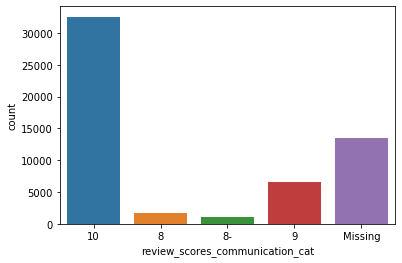

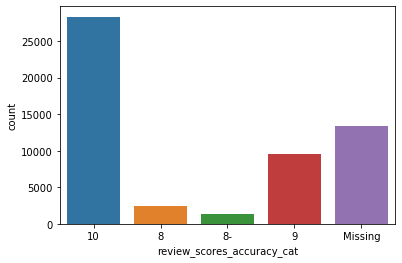

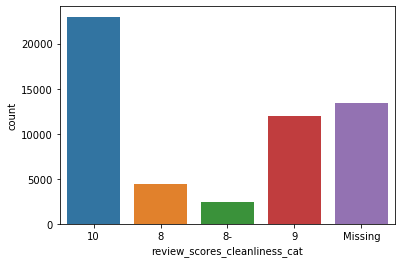

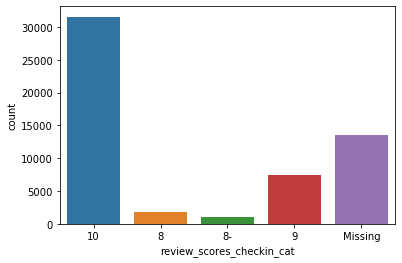

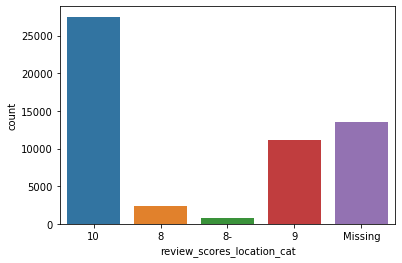

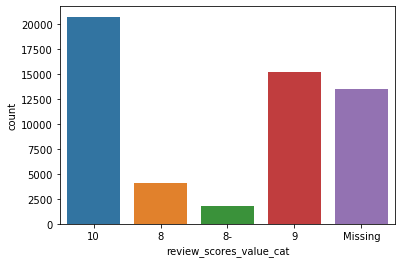

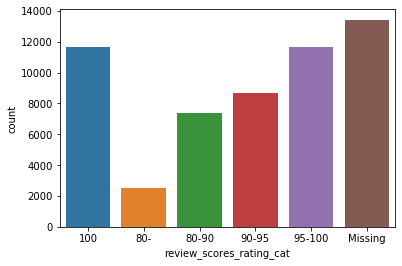

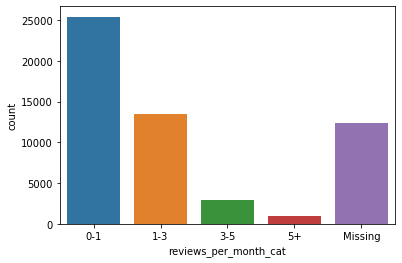

In [112]:
for i, col in enumerate(review_features_cat):
    plt.figure(i)
    sns.countplot(x=col, data=train)

In [113]:
train[review_features_cat].isna().sum()

review_scores_communication_cat    0
review_scores_accuracy_cat         0
review_scores_cleanliness_cat      0
review_scores_checkin_cat          0
review_scores_location_cat         0
review_scores_value_cat            0
review_scores_rating_cat           0
reviews_per_month_cat              0
dtype: int64

Now let's take a final look at the whole data to see whether we missed any missing values or wrong datatypes.

In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55284 entries, 0 to 55283
Data columns (total 37 columns):
experiences_offered                55284 non-null category
host_id                            55284 non-null int64
host_response_time                 55284 non-null category
host_is_superhost                  55284 non-null bool
host_has_profile_pic               55284 non-null bool
host_identity_verified             55284 non-null bool
neighbourhood_cleansed             55284 non-null category
latitude                           55284 non-null float64
longitude                          55284 non-null float64
property_type                      55284 non-null category
room_type                          55284 non-null category
accommodates                       55284 non-null int64
bathrooms                          55284 non-null float64
bedrooms                           55284 non-null float64
beds                               55284 non-null float64
bed_type                     

In [115]:
train.isna().sum()

experiences_offered                0
host_id                            0
host_response_time                 0
host_is_superhost                  0
host_has_profile_pic               0
host_identity_verified             0
neighbourhood_cleansed             0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                          0
bedrooms                           0
beds                               0
bed_type                           0
price                              0
guests_included                    0
cancellation_policy                0
listing_id                         0
name_clean                         0
description_clean                  0
neighborhood_overview_clean        0
transit_clean                      0
amenities_clean                    0
host_response_rate_cat             0
host_total_listings_count_cat      0
h

In [116]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29769 entries, 0 to 29768
Data columns (total 36 columns):
experiences_offered                29769 non-null category
host_id                            29769 non-null int64
host_response_time                 29769 non-null category
host_is_superhost                  29769 non-null bool
host_has_profile_pic               29769 non-null bool
host_identity_verified             29769 non-null bool
neighbourhood_cleansed             29769 non-null category
latitude                           29769 non-null float64
longitude                          29769 non-null float64
property_type                      29769 non-null category
room_type                          29769 non-null category
accommodates                       29769 non-null int64
bathrooms                          29769 non-null float64
bedrooms                           29769 non-null float64
beds                               29769 non-null float64
bed_type                     

In [117]:
test.isna().sum()

experiences_offered                0
host_id                            0
host_response_time                 0
host_is_superhost                  0
host_has_profile_pic               0
host_identity_verified             0
neighbourhood_cleansed             0
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                          0
bedrooms                           0
beds                               0
bed_type                           0
guests_included                    0
cancellation_policy                0
listing_id                         0
name_clean                         0
description_clean                  0
neighborhood_overview_clean        0
transit_clean                      0
amenities_clean                    0
host_response_rate_cat             0
host_total_listings_count_cat      0
host_for_days                      0
o

## 3. Model Selection

In this section of the project, first the text and the non-text columns are prepared to be used by the selected algorithms. Then the benchmark models are fitted to the data to see the initial performance which is followed by building several RNN Structures. Finally, a composite model combining text and non-text features is built.

### 3.1. Data Preparation 

The data preparation phase is carried out seperately for text and non-text columns due to wide difference between the tasks.

#### 3.1.1. Non-text Columns

For the non-text columns, the categorical variables are encoded. 2 main methods are used for encoding which are "Dummy Encoding" and "Target Encoding". Both are standard practices to deal with categorical variables. When the dimensionality of the categorical variable is low, dummy encoding is preferred for high performance. For the cases where dimensionality increases substantially, target encoding is used to decrease the size and hence computational power that is needed. When applying target encoding, the unknown and the missing data are replaced with the target mean as default which enables the algorithm to be robust to new categorical levels in the test data.

In [118]:
# Dummy encoding for categorical variables with low dimensionality
train=pd.get_dummies(train, columns = ['experiences_offered', 'host_response_time',"room_type","bed_type",
                                       "cancellation_policy","host_response_rate_cat","host_total_listings_count_cat",
                                      "review_scores_communication_cat","review_scores_accuracy_cat",
                                      "review_scores_cleanliness_cat","review_scores_checkin_cat","review_scores_location_cat",
                                      "review_scores_value_cat","review_scores_rating_cat","reviews_per_month_cat"], drop_first=True)

In [119]:
# Dummy encoding for categorical variables with low dimensionality
test=pd.get_dummies(test, columns = ['experiences_offered', 'host_response_time',"room_type","bed_type",
                                       "cancellation_policy","host_response_rate_cat","host_total_listings_count_cat",
                                      "review_scores_communication_cat","review_scores_accuracy_cat",
                                      "review_scores_cleanliness_cat","review_scores_checkin_cat","review_scores_location_cat",
                                      "review_scores_value_cat","review_scores_rating_cat","reviews_per_month_cat"], drop_first=True)

In [120]:
# Target encoding for categorical variables with high dimensionality
# Create target encoding object
encoder=ce.TargetEncoder(cols=['neighbourhood_cleansed',"property_type","outward_code"]) 
# Fit the object to train data
encoded_cols=encoder.fit_transform(train[['neighbourhood_cleansed',"property_type","outward_code"]],train['price'])
# Rename the names of the columns
encoded_cols.rename(columns = {'neighbourhood_cleansed':'neighbourhood_cleansed_new',"property_type":"property_type_new",
                              "outward_code":"outward_code_new"}, inplace = True)
# Join new columns to the dataset
train=train.join(encoded_cols)
# Drop the raw columns
train.drop(["neighbourhood_cleansed","property_type","outward_code"], inplace=True, axis=1)

In [121]:
# Target encoding for categorical variables with high dimensionality
#Fit the encoding to test data
encoded_cols_test=encoder.transform(test[['neighbourhood_cleansed',"property_type","outward_code"]], y=None, override_return_df=True)
# Rename the names of the columns
encoded_cols_test.rename(columns = {'neighbourhood_cleansed':'neighbourhood_cleansed_new',"property_type":"property_type_new",
                              "outward_code":"outward_code_new"}, inplace = True)
# Join new columns to the dataset
test=test.join(encoded_cols_test)
# Drop the raw columns
test.drop(["neighbourhood_cleansed","property_type","outward_code"], inplace=True, axis=1)

#### 3.1.2. Text Columns

For text columns, we begin with loading the pre-trained embeddings. For our embeddings, it is decided to pick 100-dimensional wiki2vec embeddings from https://wikipedia2vec.github.io/wikipedia2vec/pretrained/.

In [122]:
# Load wiki2vec embeddings:
start = time.time()
wiki2vec = KeyedVectors.load_word2vec_format('C:/Users/Berkay Kocak/Desktop/ADAMS/ASSIGNMENT_DATA/enwiki_20180420_100d.txt')
end = time.time()
print(f"Loaded wiki2vec embeddings in {end - start} seconds.")

Loaded wiki2vec embeddings in 1241.6757731437683 seconds.


The data that will be used in different nlp algorithms are formed below.

In [123]:
# Split the data into train and test set
X_nlp = train.drop(['price',"listing_id"], axis=1) 
y_nlp = train[['price']]
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(X_nlp, y_nlp , test_size=0.20, random_state=111)

In [124]:
def get_embedding_matrix(tokenizer, pretrain, vocab_size):
    '''
        Helper function to construct an embedding matrix for
        the focal corpus based on some pre-trained embeddings.
    '''

    dim = 0
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  # get embedding of an arbitrary word
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))

    # Initialize embedding matrix
    emb_mat = np.zeros((vocab_size, dim))

    # Out of vocabulary words in our corpus for which we lack a pre-trained embedding.
    oov_words = []
    # Below we use the tokenizer object that created our task vocabulary. 
    for word, i in tokenizer.word_index.items():
        # try-catch together with a zero-initilaized embedding matrix achieves our rough fix for oov words
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
    print('Created embedding matrix of shape {}'.format(emb_mat.shape))
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return emb_mat, oov_words


The embedding matrices are formed seperately for the text columns. These columns are name, amenities, description, neighborhood overview and transit. The maximum length of these seperate text features are determined according to the longest entry in the train set. The knowledge from test set can not be used since the test set should be unknown to us to prevent the data leakage. The optimum lengths that use most of the features without truncation are chosen as follows: 

Name: 25 <br>
Amenities: 200 <br>
Description: 200 <br>
Neighborhood Overview: 200 <br>
Transit: 150 <br>

The texts are all alphanumeric and in lower case anyway because of our cleaning loop.

In [125]:
# Initializing the tokenizer and fitting it on the data
tokenizer_name = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_name.fit_on_texts(X_train_nlp.name_clean)
NUM_WORDS_NAME = len(tokenizer_name.word_index) + 1

# Encoding the train data
X_tr_int_name = tokenizer_name.texts_to_sequences(X_train_nlp.name_clean)

# Finding max article length
max_article_length = max([len(article) for article in X_tr_int_name])
print('The longest name of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_NAME_LENGTH = 25

# Padding the train data
X_tr_int_pad_name = pad_sequences(X_tr_int_name, MAX_NAME_LENGTH)

# Encode and pad the test data
X_ts_int_name = tokenizer_name.texts_to_sequences(X_test_nlp.name_clean)
X_ts_int_pad_name = pad_sequences(X_ts_int_name, MAX_NAME_LENGTH)

wiki_weights_name, _ = get_embedding_matrix(tokenizer_name, wiki2vec, NUM_WORDS_NAME)

The longest name of the training set has 23 words.
Created embedding matrix of shape (5591, 100)
Encountered 801 out-of-vocabulary words.


In [126]:
# Initializing the tokenizer and fitting it on the data
tokenizer_amenities = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_amenities.fit_on_texts(X_train_nlp.amenities_clean)
NUM_WORDS_AMENITIES = len(tokenizer_amenities.word_index) + 1

# Encoding the train data
X_tr_int_amenities = tokenizer_amenities.texts_to_sequences(X_train_nlp.amenities_clean)

# Finding max article length
max_article_length = max([len(article) for article in X_tr_int_amenities])
print('The longest amenities of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_AMENITIES_LENGTH = 200

# Padding the train data
X_tr_int_pad_amenities = pad_sequences(X_tr_int_amenities, MAX_AMENITIES_LENGTH)

# Encode and pad the test data
X_ts_int_amenities = tokenizer_amenities.texts_to_sequences(X_test_nlp.amenities_clean)
X_ts_int_pad_amenities = pad_sequences(X_ts_int_amenities, MAX_AMENITIES_LENGTH)

wiki_weights_amenities, _ = get_embedding_matrix(tokenizer_amenities, wiki2vec, NUM_WORDS_AMENITIES)

The longest amenities of the training set has 200 words.
Created embedding matrix of shape (272, 100)
Encountered 0 out-of-vocabulary words.


In [127]:
# Initializing the tokenizer and fitting it on the data
tokenizer_description = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_description.fit_on_texts(X_train_nlp.description_clean)
NUM_WORDS_DESCRIPTION = len(tokenizer_description.word_index) + 1

# Encoding the train data
X_tr_int_description = tokenizer_description.texts_to_sequences(X_train_nlp.description_clean)

# Finding max article length
max_article_length = max([len(article) for article in X_tr_int_description])
print('The longest description of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_DESCRIPTION_LENGTH = 200

# Padding the train data
X_tr_int_pad_description = pad_sequences(X_tr_int_description, MAX_DESCRIPTION_LENGTH)

# Encode and pad the test data
X_ts_int_description = tokenizer_description.texts_to_sequences(X_test_nlp.description_clean)
X_ts_int_pad_description = pad_sequences(X_ts_int_description, MAX_DESCRIPTION_LENGTH)

wiki_weights_description, _ = get_embedding_matrix(tokenizer_description, wiki2vec, NUM_WORDS_DESCRIPTION)

The longest description of the training set has 197 words.
Created embedding matrix of shape (26945, 100)
Encountered 5687 out-of-vocabulary words.


In [128]:
# Initializing the tokenizer and fitting it on the data
tokenizer_neighborhood_overview = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_neighborhood_overview.fit_on_texts(X_train_nlp.neighborhood_overview_clean)
NUM_WORDS_NEIGHBORHOOD_OVERVIEW = len(tokenizer_neighborhood_overview.word_index) + 1

# Encoding the train data
X_tr_int_neighborhood_overview = tokenizer_neighborhood_overview.texts_to_sequences(X_train_nlp.neighborhood_overview_clean)

# Finding max article length
max_article_length = max([len(article) for article in X_tr_int_neighborhood_overview])
print('The longest overview of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_NEIGHBORHOOD_OVERVIEW_LENGTH = 200

# Padding the train data
X_tr_int_pad_neighborhood_overview = pad_sequences(X_tr_int_neighborhood_overview, MAX_NEIGHBORHOOD_OVERVIEW_LENGTH)

# Encode and pad the test data
X_ts_int_neighborhood_overview = tokenizer_neighborhood_overview.texts_to_sequences(X_test_nlp.neighborhood_overview_clean)
X_ts_int_pad_neighborhood_overview = pad_sequences(X_ts_int_neighborhood_overview, MAX_NEIGHBORHOOD_OVERVIEW_LENGTH)

wiki_weights_neighborhood_overview, _ = get_embedding_matrix(tokenizer_neighborhood_overview, wiki2vec, NUM_WORDS_NEIGHBORHOOD_OVERVIEW)

The longest overview of the training set has 191 words.
Created embedding matrix of shape (18104, 100)
Encountered 2179 out-of-vocabulary words.


In [129]:
# Initializing the tokenizer and fitting it on the data
tokenizer_transit = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_transit.fit_on_texts(X_train_nlp.transit_clean)
NUM_WORDS_TRANSIT = len(tokenizer_transit.word_index) + 1

# Encoding the train data
X_tr_int_transit = tokenizer_transit.texts_to_sequences(X_train_nlp.transit_clean)

# Finding max article length
max_article_length = max([len(article) for article in X_tr_int_transit])
print('The longest transit of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_TRANSIT_LENGTH = 150

# Padding the train data
X_tr_int_pad_transit = pad_sequences(X_tr_int_transit, MAX_TRANSIT_LENGTH)

# Encode and pad the test data
X_ts_int_transit = tokenizer_transit.texts_to_sequences(X_test_nlp.transit_clean)
X_ts_int_pad_transit = pad_sequences(X_ts_int_transit, MAX_TRANSIT_LENGTH)

wiki_weights_transit, _ = get_embedding_matrix(tokenizer_transit, wiki2vec, NUM_WORDS_TRANSIT)

The longest transit of the training set has 146 words.
Created embedding matrix of shape (10073, 100)
Encountered 1410 out-of-vocabulary words.


### 3.2. Benchmark Models

Benchmark models are trained for performance evaluation of the final model and keep track of our pipeline progress in terms of performance evaluation metrics. The models used on non-text data in this part are Extreme Gradient Boosting Regressor, Random Forest Regressor and Support Vector Regressor. Ensemble learners such as RFR and XGBR are especially known to be performing really good with tabular data. Additionally, a basic GRU model on text features is trained. The evaluation metrics that are used are Mean Absolute Error, Mean Squared Error and Root Mean Squared Error.

In [130]:
# Function for evaluating machine learning models, prints metrics MAE, MSE, RMSE
def evaluate_ml(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mae = mean_absolute_error(test_labels,predictions)
    mse = mean_squared_error(test_labels,predictions)
    rmse = math.sqrt(mean_squared_error(test_labels, predictions))
    print("The model:"+"\n")
    print(model,'\n')
    print('Mean Absolute Error             : {:0.4f}'.format(mae))
    print('Mean Squared Error              : {:0.2f}'.format(mse))
    print('Root Mean Square Error          : {:0.2f}'.format(rmse))

A function is created for evaluating the machine learning models to decrease the repetition for the 3 ml models that are employed. The function calculates the metrics MAE, MSE and RMSE and prints them when it is called.

In [131]:
# The data is partitioned into features and labels
X = train.drop(['price','name_clean', 'description_clean', 'neighborhood_overview_clean', 'transit_clean',"amenities_clean","listing_id"], axis=1) 
y = train[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20, random_state=111)

# Standardization of the data(Important especially for SVR.)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

The data is partitioned here for the machine learning algorithms on non-text data. Although the standardization of the data is not necessary for the tree-based algorithms such as Random Forest and Gradient Boosting, it is extremely important for Support Vector Regressors. Since in any case, standardization would not yield a decrease in performance for any of the algorithms, it is carried out for all of the algorithms that is used in this section.

#### 3.2.1. Random Forest Regressor

In [128]:
# Fitting random forest regressor model and calculating the evaluation metrics with and without cross validation
rf = RandomForestRegressor(n_estimators=300, max_depth = None, random_state=111, verbose=0, n_jobs=-1)
rf.fit(X_train, y_train.values.ravel())
evaluate_ml(rf,X_test,y_test.values.ravel())
mse_rf=cross_val_score(rf, X, y.values.ravel(), cv=5,scoring='neg_mean_squared_error')
print('Cross Validation MSE : {:0.4f}'.format(-mean(mse_rf)))

The model:

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                      oob_score=False, random_state=111, verbose=0,
                      warm_start=False) 

Mean Absolute Error             : 29.1446
Mean Squared Error              : 2334.05
Root Mean Square Error          : 48.31
Cross Validation MSE : 2342.5486


Random Forest Regressor shows a very good performance on the train data. The cross-validation MSE also proves the robustness of the results. The model can be further improved by hyperparameter tuning with the deployment of a grid search. However, for now the hyperparameters such as number of trees in the forest("n_estimators") are determined in an experimental fashion for the benchmark model. Random state is fixed for reproducibility of the results.

#### 3.2.2. Extreme Gradient Regressor

In [92]:
# Fitting extreme gradient regressor model and calculating the evaluation metrics with and without cross validation
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.1,
                max_depth=2, alpha=20, n_estimators = 300)
xg_reg.fit(X_train,y_train)

evaluate_ml(xg_reg,X_test,y_test.values.ravel())
mse_xg_reg=cross_val_score(xg_reg, X, y.values.ravel(), cv=5,scoring='neg_mean_squared_error')
print('Cross Validation MSE : {:0.4f}'.format(-mean(mse_xg_reg)))

The model:

XGBRegressor(alpha=20, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=20,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 

Mean Absolute Error             : 31.3323
Mean Squared Error              : 2633.28
Root Mean Square Error          : 51.32
Cross Validation MSE : 2605.2479


Extreme Gradiend Regressor performs worse compared to Random Forest for all of the metrics of interest. The hyperparameters of the model such as number of gradient boosted trees("n_estimators"), max depth for tree learners("max_depth"), boosting learning rate("learning_rate") are again determined in an experimental setup.

#### 3.2.3. Support Vector Regressor

In [93]:
# Fitting support vector regressor model and calculating the evaluation metrics with and without cross validation
svr = svm.SVR(kernel='rbf',gamma="scale",C=10)
svr.fit(X_train, y_train.values.ravel())
evaluate_ml(svr,X_test,y_test.values.ravel())
mse_svr=cross_val_score(svr, X, y.values.ravel(), cv=5,scoring='neg_mean_squared_error')
print('Cross Validation MSE : {:0.4f}'.format(-mean(mse_svr)))

The model:

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

Mean Absolute Error             : 30.3856
Mean Squared Error              : 2886.01
Root Mean Square Error          : 53.72
Cross Validation MSE : 7558.3193


Support Vector Regressor achieves the worst performance on the train dataset for the non-text features. Cross- Validation MSE is increased substantially for this particular model which proves that the model is not robust.

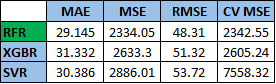

In [135]:
display.Image("C:/Users/Berkay Kocak/Desktop/ml_models.png")

The analysis of the models deployed on the non-text data gives an overall overview for the predictive performance of tabular data in hand. Random forest regressor seems to outperform other models in each of the performance evaluation metrics. SVR performs in a highly unstable manner. The outstanding performance of random forest is not a very surprising outcome given the large number of categorical variables that the dataset has or that are created.

#### 3.2.4. GRU

As a benchmark model for the text features, a basic GRU model is also trained. It is a basic NLP model with self-trained embeddings.In the RNN structure part, pretrained embeddings from wiki2vec is used.

The input shapes are determined according to the maximum words that the features contains as explained before. The hidden units in GRUs is set to 100, and activation functions are determined as ReLu. The main advantage of using ReLu over other options is that it does not activate all neurons at the same time which makes it computationally more efficient.

Several batch sizes are tried including 32, 64, 128 and 256. The optimal performance according to runtime is achieved with a batch size of 32. Therefore, the batch size is kept as 32 for the following parts. 

Early stopping is also incorporated in the model. In case the model does not improve in terms of validation loss for 3 epochs, the kernel is interrupted and the model is chosen as the one in the final epoch.

Finally, log-cosh loss, which behaves very similarly to MAE, is used as a performance metric of the algorithm due to its computational performance. Mean squared error is eliminated as an option due to not being robust to outliers.

In [132]:
# Inputs
input_name = Input(shape=(25, ))
input_amenities = Input(shape=(200, ))
input_description = Input(shape=(200, ))
input_neighborhood_overview = Input(shape=(200, ))
input_transit = Input(shape=(150, ))

# Name
name_embeddings = Embedding(input_dim=NUM_WORDS_NAME, output_dim=100, input_length=25)(input_name)
GRU_name = GRU(100)(name_embeddings)
dense_name = Dense(1, activation="relu")(GRU_name)

# Amenities
amenities_embeddings = Embedding(input_dim=NUM_WORDS_AMENITIES, output_dim=100, input_length=200)(input_amenities)
GRU_amenities = GRU(100)(amenities_embeddings)
dense_amenities = Dense(1, activation="relu")(GRU_amenities)

# Description
description_embeddings = Embedding(input_dim=NUM_WORDS_DESCRIPTION, output_dim=100, input_length=200)(input_description)
GRU_description = GRU(100)(description_embeddings)
dense_description = Dense(1, activation="relu")(GRU_description)

# Neighbourhood Overview
neighborhood_overview_embeddings = Embedding(input_dim=NUM_WORDS_NEIGHBORHOOD_OVERVIEW, output_dim=100, input_length=200)(input_neighborhood_overview)
GRU_neighborhood_overview = GRU(100)(neighborhood_overview_embeddings)
dense_neighborhood_overview = Dense(1, activation="relu")(GRU_neighborhood_overview)

# Transit
transit_embeddings = Embedding(input_dim=NUM_WORDS_TRANSIT, output_dim=100, input_length=150)(input_transit)
GRU_transit = GRU(100)(transit_embeddings)
dense_transit = Dense(1, activation="relu")(GRU_transit)

# Concatenate
output_layer = concatenate([dense_name, dense_amenities, dense_description,dense_neighborhood_overview,dense_transit])

model = Model(inputs=[input_name, input_amenities, input_description,input_neighborhood_overview,input_transit], outputs=output_layer)
model.compile(loss=losses.LogCosh(), optimizer="adam", metrics=["mae", "mse"])

print(model.summary())
callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.1, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_name, X_tr_int_pad_amenities, X_tr_int_pad_description, X_tr_int_pad_neighborhood_overview, X_tr_int_pad_transit], y_train_nlp, epochs=10, verbose=1, batch_size=32, 
          validation_split=0.2, callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 200)]        0                                            
______________________________________________________________________________________________

In [134]:
# Creating a dataframe consisting of predictions and actual
preds = pd.DataFrame(model.predict([X_ts_int_pad_name,X_ts_int_pad_amenities, X_ts_int_pad_description,X_ts_int_pad_neighborhood_overview,X_ts_int_pad_transit])
                     , columns=["name_pred", "amenities_pred", "description_pred","neighborhood_overview_pred","transit_pred"], index=y_test_nlp.index)
preds["actual"] = y_test_nlp

In [135]:
print(f"Name MSE: {mean_squared_error(preds.name_pred, preds.actual)}")
print(f"Name MAE: {mean_absolute_error(preds.name_pred, preds.actual)}\n") 
print(f"Description MSE: {mean_squared_error(preds.description_pred, preds.actual)}")
print(f"Description MAE: {mean_absolute_error(preds.description_pred, preds.actual)}\n")
print(f"Neighborhood Overview MSE: {mean_squared_error(preds.neighborhood_overview_pred, preds.actual)}")
print(f"Neighborhood Overview MAE: {mean_absolute_error(preds.neighborhood_overview_pred, preds.actual)}\n")
print(f"Transit MSE: {mean_squared_error(preds.transit_pred, preds.actual)}")
print(f"Transit MAE: {mean_absolute_error(preds.transit_pred, preds.actual)}\n")
print(f"Amenities MSE: {mean_squared_error(preds.amenities_pred, preds.actual)}")
print(f"Amenities MAE: {mean_absolute_error(preds.amenities_pred, preds.actual)}\n")

Name MSE: 4274.806002844897
Name MAE: 38.75282531488844

Description MSE: 4394.425707875019
Description MAE: 39.493137542298186

Neighborhood Overview MSE: 6203.765739992118
Neighborhood Overview MAE: 50.474361399667565

Transit MSE: 6482.593680411332
Transit MAE: 51.433576846237024

Amenities MSE: 5177.857504773706
Amenities MAE: 43.12088809393301



GRU Model seems to be performing worse compared to other ensemble learners. Therefore, one can conclude that textual data has a lower predictive power compared to structured data. However, this will be analysed further in the following sections by introduction of other models.

### 3.3. RNN Structure

The RNN structures that are tried in this notebook are LSTM, Bidirectional LSTM and Stacked LSTM. The parameters are the same as the ones that are used in GRU model due to similar reasonings.

#### 3.3.1 LSTM

In [136]:
# Inputs
input_name = Input(shape=(25, ))
input_amenities = Input(shape=(200, ))
input_description = Input(shape=(200, ))
input_neighborhood_overview = Input(shape=(200, ))
input_transit = Input(shape=(150, ))

# Name
name_embeddings = Embedding(NUM_WORDS_NAME, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_name),
                     input_length=25, trainable=True)(input_name)
LSTM_name = LSTM(100, return_sequences=False)(name_embeddings)
dense_name = Dense(1, activation="relu")(LSTM_name)

# Amenities
amenities_embeddings = Embedding(NUM_WORDS_AMENITIES, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_amenities),
                     input_length=200, trainable=True)(input_amenities)
LSTM_amenities = LSTM(100, return_sequences=False)(amenities_embeddings)
dense_amenities = Dense(1, activation="relu")(LSTM_amenities)

# Description
description_embeddings = Embedding(NUM_WORDS_DESCRIPTION, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_description),
                     input_length=200, trainable=True)(input_description)
LSTM_description = LSTM(100, return_sequences=False)(description_embeddings)
dense_description = Dense(1, activation="relu")(LSTM_description)

# Neighborhood_Overview
neighborhood_overview_embeddings = Embedding(NUM_WORDS_NEIGHBORHOOD_OVERVIEW, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_neighborhood_overview),
                     input_length=200, trainable=True)(input_neighborhood_overview)
LSTM_neighborhood_overview = LSTM(100, return_sequences=False)(neighborhood_overview_embeddings)
dense_neighborhood_overview = Dense(1, activation="relu")(LSTM_neighborhood_overview)

# Transit
transit_embeddings = Embedding(NUM_WORDS_TRANSIT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_transit),
                     input_length=150, trainable=True)(input_transit)
LSTM_transit = LSTM(100, return_sequences=False)(transit_embeddings)
dense_transit = Dense(1, activation="relu")(LSTM_transit)

# Concatenate
output_layer = concatenate([dense_name, dense_amenities, dense_description, dense_neighborhood_overview, dense_transit])

model = Model(inputs=[input_name, input_amenities, input_description, input_neighborhood_overview, input_transit], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_name, X_tr_int_pad_amenities, X_tr_int_pad_description, X_tr_int_pad_neighborhood_overview, X_tr_int_pad_transit],
                  y_train_nlp, epochs=15, verbose=1, batch_size=32, validation_split=0.2, callbacks=callbacks)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 200)]        0                                            
____________________________________________________________________________________________

In [137]:
# Creating a dataframe consisting of predictions and actual
preds = pd.DataFrame(model.predict([X_ts_int_pad_name, X_ts_int_pad_amenities, X_ts_int_pad_description, X_ts_int_pad_neighborhood_overview, X_ts_int_pad_transit])
                     , columns=["name_pred", "amenities_pred", "description_pred","neighborhood_overview_pred", "transit_pred"], index=y_test_nlp.index)
preds["actual"] = y_test_nlp

In [138]:
print(f"Name MSE: {mean_squared_error(preds.name_pred, preds.actual)}")
print(f"Name MAE: {mean_absolute_error(preds.name_pred, preds.actual)}\n") 
print(f"Description MSE: {mean_squared_error(preds.description_pred, preds.actual)}")
print(f"Description MAE: {mean_absolute_error(preds.description_pred, preds.actual)}\n")
print(f"Neighborhood Overview MSE: {mean_squared_error(preds.neighborhood_overview_pred, preds.actual)}")
print(f"Neighborhood Overview MAE: {mean_absolute_error(preds.neighborhood_overview_pred, preds.actual)}\n")
print(f"Transit MSE: {mean_squared_error(preds.transit_pred, preds.actual)}")
print(f"Transit MAE: {mean_absolute_error(preds.transit_pred, preds.actual)}\n")
print(f"Amenities MSE: {mean_squared_error(preds.amenities_pred, preds.actual)}")
print(f"Amenities MAE: {mean_absolute_error(preds.amenities_pred, preds.actual)}\n")

Name MSE: 4238.688488589363
Name MAE: 38.9125216232994

Description MSE: 4239.733242351325
Description MAE: 39.39853160855912

Neighborhood Overview MSE: 6233.5709128031085
Neighborhood Overview MAE: 50.51264819407146

Transit MSE: 6438.793336501508
Transit MAE: 51.501927194580674

Amenities MSE: 5015.39049251617
Amenities MAE: 42.21676665610815



LSTM Model already performs slightly better compared to GRU looking at the outputs. However, two other versions of LSTM will also be tried before coming up with the final modelling decision.

#### 3.3.2 Bidirectional LSTM

In [157]:
# Inputs
input_name = Input(shape=(25, ))
input_amenities = Input(shape=(200, ))
input_description = Input(shape=(200, ))
input_neighborhood_overview = Input(shape=(200, ))
input_transit = Input(shape=(150, ))

# Name
name_embeddings = Embedding(NUM_WORDS_NAME, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_name),
                     input_length=25, trainable=True)(input_name)
LSTM_name = Bidirectional(LSTM(100, return_sequences=False),merge_mode="concat")(name_embeddings)
dense_name = Dense(1, activation="relu")(LSTM_name)

# Amenities
amenities_embeddings = Embedding(NUM_WORDS_AMENITIES, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_amenities),
                     input_length=200, trainable=True)(input_amenities)
LSTM_amenities = Bidirectional(LSTM(100, return_sequences=False),merge_mode="concat")(amenities_embeddings)
dense_amenities = Dense(1, activation="relu")(LSTM_amenities)

# Description
description_embeddings = Embedding(NUM_WORDS_DESCRIPTION, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_description),
                     input_length=200, trainable=True)(input_description)
LSTM_description = Bidirectional(LSTM(100, return_sequences=False),merge_mode="concat")(description_embeddings)
dense_description = Dense(1, activation="relu")(LSTM_description)

# Neighborhood_Overview
neighborhood_overview_embeddings = Embedding(NUM_WORDS_NEIGHBORHOOD_OVERVIEW, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_neighborhood_overview),
                     input_length=200, trainable=True)(input_neighborhood_overview)
LSTM_neighborhood_overview = Bidirectional(LSTM(100, return_sequences=False),merge_mode="concat")(neighborhood_overview_embeddings)
dense_neighborhood_overview = Dense(1, activation="relu")(LSTM_neighborhood_overview)

# Transit
transit_embeddings = Embedding(NUM_WORDS_TRANSIT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_transit),
                     input_length=150, trainable=True)(input_transit)
LSTM_transit = Bidirectional(LSTM(100, return_sequences=False),merge_mode="concat")(transit_embeddings)
dense_transit = Dense(1, activation="relu")(LSTM_transit)

# Concatenate
output_layer = concatenate([dense_name, dense_amenities, dense_description, dense_neighborhood_overview, dense_transit])

model = Model(inputs=[input_name, input_amenities, input_description, input_neighborhood_overview, input_transit], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_name, X_tr_int_pad_amenities, X_tr_int_pad_description, X_tr_int_pad_neighborhood_overview, X_tr_int_pad_transit],
                  y_train_nlp, epochs=10, verbose=1, batch_size=32, validation_split=0.2, callbacks=callbacks)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           [(None, 200)]        0                                            
____________________________________________________________________________________________

In [158]:
# Creating a dataframe consisting of predictions and actual
preds = pd.DataFrame(model.predict([X_ts_int_pad_name, X_ts_int_pad_amenities, X_ts_int_pad_description,X_ts_int_pad_neighborhood_overview,X_ts_int_pad_transit])
                     , columns=["name_pred", "amenities_pred", "description_pred","neighborhood_overview_pred","transit_pred"], index=y_test_nlp.index)
preds["actual"] = y_test_nlp

In [159]:
print(f"Name MSE: {mean_squared_error(preds.name_pred, preds.actual)}")
print(f"Name MAE: {mean_absolute_error(preds.name_pred, preds.actual)}\n") 
print(f"Description MSE: {mean_squared_error(preds.description_pred, preds.actual)}")
print(f"Description MAE: {mean_absolute_error(preds.description_pred, preds.actual)}\n")
print(f"Neighborhood Overview MSE: {mean_squared_error(preds.neighborhood_overview_pred, preds.actual)}")
print(f"Neighborhood Overview MAE: {mean_absolute_error(preds.neighborhood_overview_pred, preds.actual)}\n")
print(f"Transit MSE: {mean_squared_error(preds.transit_pred, preds.actual)}")
print(f"Transit MAE: {mean_absolute_error(preds.transit_pred, preds.actual)}\n")
print(f"Amenities MSE: {mean_squared_error(preds.amenities_pred, preds.actual)}")
print(f"Amenities MAE: {mean_absolute_error(preds.amenities_pred, preds.actual)}\n")

Name MSE: 4193.281370552134
Name MAE: 38.5997268168396

Description MSE: 4403.220201546038
Description MAE: 39.57630418982915

Neighborhood Overview MSE: 6127.183350356514
Neighborhood Overview MAE: 50.44555208175644

Transit MSE: 6358.1817259204
Transit MAE: 51.270985107304575

Amenities MSE: 4870.432768212281
Amenities MAE: 41.906777336960346



Bidirectional LSTM seems to perform slightly better compared to LSTM. However, this performance comes at a cost of runtime. Each iteration in the bidirectional LSTM takes nearly twice as longer compared to LSTM due to its structure. Therefore, LSTM is a more favorable structure for the final model.

#### 3.3.3 Stacked LSTM

In [141]:
# Inputs
input_name = Input(shape=(25, ))
input_amenities = Input(shape=(200, ))
input_description = Input(shape=(200, ))
input_neighborhood_overview = Input(shape=(200, ))
input_transit = Input(shape=(150, ))

# Name
name_embeddings = Embedding(NUM_WORDS_NAME, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_name),
                     input_length=25, trainable=True)(input_name)
LSTM_name_1 = LSTM(100, return_sequences=True)(name_embeddings)
LSTM_name_2 = LSTM(50, return_sequences=False)(LSTM_name_1)
dense_name = Dense(1, activation="relu")(LSTM_name_2)

# Amenities
amenities_embeddings = Embedding(NUM_WORDS_AMENITIES, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_amenities),
                     input_length=200, trainable=True)(input_amenities)
LSTM_amenities_1 = LSTM(100, return_sequences=True)(amenities_embeddings)
LSTM_amenities_2 = LSTM(50, return_sequences=False)(LSTM_amenities_1)
dense_amenities = Dense(1, activation="relu")(LSTM_amenities_2)

# Description
description_embeddings = Embedding(NUM_WORDS_DESCRIPTION, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_description),
                     input_length=200, trainable=True)(input_description)
LSTM_description_1 = LSTM(100, return_sequences=True)(description_embeddings)
LSTM_description_2 = LSTM(50, return_sequences=False)(LSTM_description_1)
dense_description = Dense(1, activation="relu")(LSTM_description_2)

# Neighborhood_Overview
neighborhood_overview_embeddings = Embedding(NUM_WORDS_NEIGHBORHOOD_OVERVIEW, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_neighborhood_overview),
                     input_length=200, trainable=True)(input_neighborhood_overview)
LSTM_neighborhood_overview_1 = LSTM(100, return_sequences=True)(neighborhood_overview_embeddings)
LSTM_neighborhood_overview_2 = LSTM(50, return_sequences=False)(LSTM_neighborhood_overview_1)
dense_neighborhood_overview = Dense(1, activation="relu")(LSTM_neighborhood_overview_2)

# Transit
transit_embeddings = Embedding(NUM_WORDS_TRANSIT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_transit),
                     input_length=150, trainable=True)(input_transit)
LSTM_transit_1 = LSTM(100, return_sequences=True)(transit_embeddings)
LSTM_transit_2 = LSTM(50, return_sequences=False)(LSTM_transit_1)
dense_transit = Dense(1, activation="relu")(LSTM_transit_2)

# Concatenate
output_layer = concatenate([dense_name, dense_amenities, dense_description, dense_neighborhood_overview, dense_transit])

model = Model(inputs=[input_name, input_amenities, input_description, input_neighborhood_overview, input_transit], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_name, X_tr_int_pad_amenities, X_tr_int_pad_description, X_tr_int_pad_neighborhood_overview, X_tr_int_pad_transit],
                  y_train_nlp, epochs=10, verbose=1, batch_size=32, validation_split=0.2, callbacks=callbacks)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 200)]        0                                            
____________________________________________________________________________________________

In [142]:
# Creating a dataframe consisting of predictions and actual
preds = pd.DataFrame(model.predict([X_ts_int_pad_name, X_ts_int_pad_amenities, X_ts_int_pad_description,X_ts_int_pad_neighborhood_overview,X_ts_int_pad_transit])
                     , columns=["name_pred","amenities_pred","description_pred","neighborhood_overview_pred","transit_pred"], index=y_test_nlp.index)
preds["actual"] = y_test_nlp

In [143]:
print(f"Name MSE: {mean_squared_error(preds.name_pred, preds.actual)}")
print(f"Name MAE: {mean_absolute_error(preds.name_pred, preds.actual)}\n") 
print(f"Description MSE: {mean_squared_error(preds.description_pred, preds.actual)}")
print(f"Description MAE: {mean_absolute_error(preds.description_pred, preds.actual)}\n")
print(f"Neighborhood Overview MSE: {mean_squared_error(preds.neighborhood_overview_pred, preds.actual)}")
print(f"Neighborhood Overview MAE: {mean_absolute_error(preds.neighborhood_overview_pred, preds.actual)}\n")
print(f"Transit MSE: {mean_squared_error(preds.transit_pred, preds.actual)}")
print(f"Transit MAE: {mean_absolute_error(preds.transit_pred, preds.actual)}\n")
print(f"Amenities MSE: {mean_squared_error(preds.amenities_pred, preds.actual)}")
print(f"Amenities MAE: {mean_absolute_error(preds.amenities_pred, preds.actual)}\n")

Name MSE: 4499.788531912362
Name MAE: 39.511619682584566

Description MSE: 7245.548118359234
Description MAE: 55.52124406942744

Neighborhood Overview MSE: 7249.982246711495
Neighborhood Overview MAE: 55.51916050710417

Transit MSE: 6833.79882362264
Transit MAE: 52.74352321847283

Amenities MSE: 5411.86916624837
Amenities MAE: 43.74677570415813



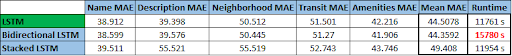

In [136]:
display.Image("C:/Users/Berkay Kocak/Desktop/dl_models.png")

Stacked LSTM shows the poorest performance among the alternatives. Therefore, it is eliminated as an alternative for the final model. Although, bidirectional LSTM shows a slightly better predictive performance compared to LSTM, it requires far more computational power. (The runtimes are computed in 15 epochs for LSTM and 10 epochs for Bidirectional LSTM). Therefore LSTM proves to show the highest performance among alternatives and chosen as the model to be deployed for the composite structure.

### 3.4 Complete Model

The last step of the assignment is to bring the text and non-text columns together to utilize both of their predictive powers. Although there are several ways to do this, in this assignment it is done by creating a single composite model. The final design of the model created by following these steps. Firstly, several LSTMs are trained for different text data and each of them created a single linear value. Afterwards, these values are concatenated with the non-text data. Finally, a deep neural network with the concatenated features are trained. 

In [132]:
# Dropping the nontext columns for nontext features and preparing them for the algorithm by setting the type.
X_train_n=X_train_nlp.drop(columns=['name_clean','description_clean','neighborhood_overview_clean', 'transit_clean','amenities_clean'])
X_test_n=X_test_nlp.drop(columns=['name_clean','description_clean','neighborhood_overview_clean', 'transit_clean','amenities_clean'])

In [133]:
# Preparing the label for the algorithm by setting the type
y_train_n=np.asarray(y_train_nlp).astype(np.int)

In [134]:
# Normalization
scaler = MinMaxScaler()
scaler.fit(X_train_n)
X_train_n = scaler.transform(X_train_n)
X_test_n = scaler.transform(X_test_n)

Normalization becomes an important step when the tabular data is united with the text data. The tabular data itself should be standardized to prevent the data with large values from dominating other inputs. 

In [135]:
# Inputs
input_name = Input(shape=(25, ))
input_amenities = Input(shape=(200, ))
input_description = Input(shape=(200, ))
input_neighborhood_overview = Input(shape=(200, ))
input_transit = Input(shape=(150, ))
input_nontext = Input(shape=(79, ))

# Name
name_embeddings = Embedding(NUM_WORDS_NAME, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_name),
                     input_length=25, trainable=False)(input_name)
LSTM_name = LSTM(100, return_sequences=False)(name_embeddings)
dense_name = Dense(1, activation="linear")(LSTM_name)

# Amenities
amenities_embeddings = Embedding(NUM_WORDS_AMENITIES, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_amenities),
                     input_length=200, trainable=False)(input_amenities)
LSTM_amenities = LSTM(100, return_sequences=False)(amenities_embeddings)
dense_amenities = Dense(1, activation="linear")(LSTM_amenities)

# Description
description_embeddings = Embedding(NUM_WORDS_DESCRIPTION, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_description),
                     input_length=200, trainable=False)(input_description)
LSTM_description = LSTM(100, return_sequences=False)(description_embeddings)
dense_description = Dense(1, activation="linear")(LSTM_description)

# Neighborhood_Overview
neighborhood_overview_embeddings = Embedding(NUM_WORDS_NEIGHBORHOOD_OVERVIEW, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_neighborhood_overview),
                     input_length=200, trainable=False)(input_neighborhood_overview)
LSTM_neighborhood_overview = LSTM(100, return_sequences=False)(neighborhood_overview_embeddings)
dense_neighborhood_overview = Dense(1, activation="linear")(LSTM_neighborhood_overview)

# Transit
transit_embeddings = Embedding(NUM_WORDS_TRANSIT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_transit),
                     input_length=150, trainable=False)(input_transit)
LSTM_transit = LSTM(100, return_sequences=False)(transit_embeddings)
dense_transit = Dense(1, activation="linear")(LSTM_transit)

# Concatenate
concat = concatenate([dense_name, dense_amenities, dense_description,dense_neighborhood_overview,dense_transit,input_nontext])
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

model = Model(inputs=[input_name,input_amenities, input_description, input_neighborhood_overview,input_transit,input_nontext], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_name, X_tr_int_pad_amenities, X_tr_int_pad_description, X_tr_int_pad_neighborhood_overview, 
                   X_tr_int_pad_transit, X_train_n ]
                  , y_train_n , epochs=30, verbose=1, batch_size=32, validation_split=0.2, callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 200)]        0                                            
______________________________________________________________________________________________

In [136]:
preds = pd.DataFrame(model.predict([X_ts_int_pad_name, X_ts_int_pad_amenities, X_ts_int_pad_description, X_ts_int_pad_neighborhood_overview, X_ts_int_pad_transit, X_test_n ]), columns=["pred"], index=X_test_nlp.index)
preds["actual"] = y_test_nlp

In [137]:
print(f"Complete Model MSE:  {mean_squared_error(preds.pred, preds.actual)}")
print(f"Complete Model RMSE: {math.sqrt(mean_squared_error(preds.pred, preds.actual))}")
print(f"Complete Model MAE:  {mean_absolute_error(preds.pred, preds.actual)}\n")

Complete Model MSE:  2496.2685587144224
Complete Model RMSE: 49.962671653089394
Complete Model MAE:  27.976364688436863



In [138]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax1.plot(story.history['mae'])
    ax1.plot(story.history['val_mae'])
    ax1.set(xlabel='epoch', ylabel='MAE')
    ax1.legend(['train_mae', 'test_mae'], loc='best')
    ax1.set_title('MAE evolution during NN training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during NN training')
    plt.show()

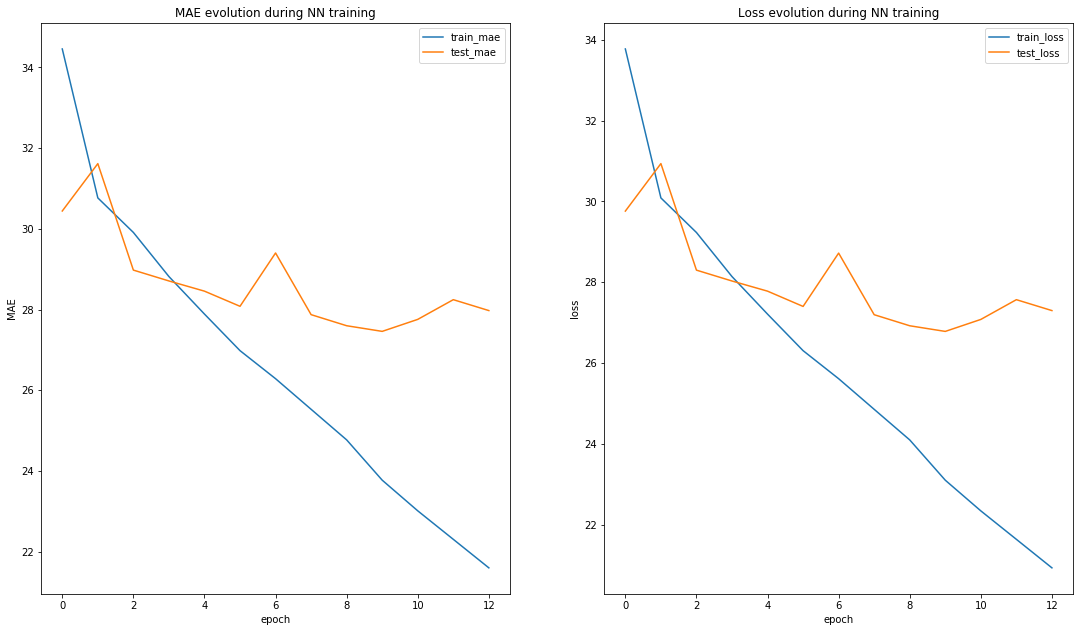

In [139]:
show_history(story)

Early stopping seems to work with a patience level of 3. The overfitting behavior of the model is prevented. The comparison of the best model with the previous best(RFR) can be seen below.

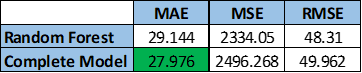

In [142]:
display.Image("C:/Users/Berkay Kocak/Desktop/complete_model.png")

The model performance seems to be slightly better compared to ensemble learners in terms of MAE which was chosen as the main performance criteria due to its robustness. However Random Forest outperforms the Complete Model in terms of other metrics. The high performance of the RFR only on numeric data proves that either the textual data is not providing an additional predictive power for this particular task or the model structure is not reveal the full potential of the data. A better approach might be feeding the results of textual network to an ensemble learner which might boost its performance. However, this will not be analysed in this project due to time constraints. 

Ultimately, the Complete Model is also applied to the test data in the next section. 

## 4. Application to Test Data

In [132]:
# Creating the new train and test data
X_test_nlp = test.drop(["listing_id"], axis=1) 
X_train_nlp = X_nlp
y_train_nlp = y_nlp

In [133]:
# Dropping the nontext columns for nontext features
X_train_n=X_train_nlp.drop(columns=['name_clean','description_clean','neighborhood_overview_clean', 'transit_clean','amenities_clean'])
X_test_n=X_test_nlp.drop(columns=['name_clean','description_clean','neighborhood_overview_clean', 'transit_clean','amenities_clean'])

In [134]:
# If a category level is absent in the test data, set the related column to zero.
for column in X_train_n.columns:
    if column not in X_test_n.columns:
        X_test_n[column] = 0

In this section, it is analysed that for the feature "cancellation policy", two category levels are not observed on the test set. These levels are namely "luxury_moderate" and "luxury_super_strict_95". 

In the code above, to prevent any errors, the columns associating with the new category levels are added as new columns consisting of zeros.

In [135]:
# Columns are reindexed.
column_names = X_train_n.columns
X_test_n = X_test_n.reindex(columns=column_names)

Since the created columns are added at the end of the dataset, they should be reindexed according to the train dataset. This operation is handled in the code cell above.

In [138]:
# Normalization of the data
scaler = MinMaxScaler()
scaler.fit(X_train_n)
X_train_n = scaler.transform(X_train_n)
X_test_n = scaler.transform(X_test_n)

The data again should be normalized to prevent columns with larger values from dominating other columns.

In [139]:
# Preparing the label for the algorithm by setting the type
y_train_n=np.asarray(y_train_nlp).astype(np.int)

Tokenized objects and embedding matrices are initialized once more for the new test set. The share of out of vocabulary words for the test set is observed to be higher.

In [141]:
# Initializing the tokenizer and fitting it on the data
tokenizer_name = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_name.fit_on_texts(X_train_nlp.name_clean)
NUM_WORDS_NAME = len(tokenizer_name.word_index) + 1

# Encoding the train data
X_tr_int_name = tokenizer_name.texts_to_sequences(X_train_nlp.name_clean)

# Finding max article length
max_article_length = max([len(article) for article in X_tr_int_name])
print('The longest name of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_NAME_LENGTH = 25

# Padding the train data
X_tr_int_pad_name = pad_sequences(X_tr_int_name, MAX_NAME_LENGTH)

# Encode and pad the test data
X_ts_int_name = tokenizer_name.texts_to_sequences(X_test_nlp.name_clean)
X_ts_int_pad_name = pad_sequences(X_ts_int_name, MAX_NAME_LENGTH)

wiki_weights_name, _ = get_embedding_matrix(tokenizer_name, wiki2vec, NUM_WORDS_NAME)

The longest name of the training set has 30 words.
Created embedding matrix of shape (6218, 100)
Encountered 961 out-of-vocabulary words.


In [142]:
# Initializing the tokenizer and fitting it on the data
tokenizer_amenities = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_amenities.fit_on_texts(X_train_nlp.amenities_clean)
NUM_WORDS_AMENITIES = len(tokenizer_amenities.word_index) + 1

# Encoding the train data
X_tr_int_amenities = tokenizer_amenities.texts_to_sequences(X_train_nlp.amenities_clean)

# Finding max article length
max_article_length = max([len(article) for article in X_tr_int_amenities])
print('The longest amenities of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_AMENITIES_LENGTH = 200

# Padding the train data
X_tr_int_pad_amenities = pad_sequences(X_tr_int_amenities, MAX_AMENITIES_LENGTH)

# Encode and pad the test data
X_ts_int_amenities = tokenizer_amenities.texts_to_sequences(X_test_nlp.amenities_clean)
X_ts_int_pad_amenities = pad_sequences(X_ts_int_amenities, MAX_AMENITIES_LENGTH)

wiki_weights_amenities, _ = get_embedding_matrix(tokenizer_amenities, wiki2vec, NUM_WORDS_AMENITIES)

The longest amenities of the training set has 200 words.
Created embedding matrix of shape (274, 100)
Encountered 0 out-of-vocabulary words.


In [143]:
# Initializing the tokenizer and fitting it on the data
tokenizer_description = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_description.fit_on_texts(X_train_nlp.description_clean)
NUM_WORDS_DESCRIPTION = len(tokenizer_description.word_index) + 1

# Encoding the train data
X_tr_int_description = tokenizer_description.texts_to_sequences(X_train_nlp.description_clean)

# Finding max article length
max_article_length = max([len(article) for article in X_tr_int_description])
print('The longest description of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_DESCRIPTION_LENGTH = 200

# Padding the train data
X_tr_int_pad_description = pad_sequences(X_tr_int_description, MAX_DESCRIPTION_LENGTH)

# Encode and pad the test data
X_ts_int_description = tokenizer_description.texts_to_sequences(X_test_nlp.description_clean)
X_ts_int_pad_description = pad_sequences(X_ts_int_description, MAX_DESCRIPTION_LENGTH)

wiki_weights_description, _ = get_embedding_matrix(tokenizer_description, wiki2vec, NUM_WORDS_DESCRIPTION)

The longest description of the training set has 197 words.
Created embedding matrix of shape (29763, 100)
Encountered 6698 out-of-vocabulary words.


In [144]:
# Initializing the tokenizer and fitting it on the data
tokenizer_neighborhood_overview = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_neighborhood_overview.fit_on_texts(X_train_nlp.neighborhood_overview_clean)
NUM_WORDS_NEIGHBORHOOD_OVERVIEW = len(tokenizer_neighborhood_overview.word_index) + 1

# Encoding the train data
X_tr_int_neighborhood_overview = tokenizer_neighborhood_overview.texts_to_sequences(X_train_nlp.neighborhood_overview_clean)

# Finding max article length
max_article_length = max([len(article) for article in X_tr_int_neighborhood_overview])
print('The longest overview of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_NEIGHBORHOOD_OVERVIEW_LENGTH = 200

# Padding the train data
X_tr_int_pad_neighborhood_overview = pad_sequences(X_tr_int_neighborhood_overview, MAX_NEIGHBORHOOD_OVERVIEW_LENGTH)

# Encode and pad the test data
X_ts_int_neighborhood_overview = tokenizer_neighborhood_overview.texts_to_sequences(X_test_nlp.neighborhood_overview_clean)
X_ts_int_pad_neighborhood_overview = pad_sequences(X_ts_int_neighborhood_overview, MAX_NEIGHBORHOOD_OVERVIEW_LENGTH)

wiki_weights_neighborhood_overview, _ = get_embedding_matrix(tokenizer_neighborhood_overview, wiki2vec, NUM_WORDS_NEIGHBORHOOD_OVERVIEW)

The longest overview of the training set has 191 words.
Created embedding matrix of shape (19714, 100)
Encountered 2558 out-of-vocabulary words.


In [145]:
# Initializing the tokenizer and fitting it on the data
tokenizer_transit = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_transit.fit_on_texts(X_train_nlp.transit_clean)
NUM_WORDS_TRANSIT = len(tokenizer_transit.word_index) + 1

# Encoding the train data
X_tr_int_transit = tokenizer_transit.texts_to_sequences(X_train_nlp.transit_clean)

# Finding max article length
max_article_length = max([len(article) for article in X_tr_int_transit])
print('The longest transit of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_TRANSIT_LENGTH = 150

# Padding the train data
X_tr_int_pad_transit = pad_sequences(X_tr_int_transit, MAX_TRANSIT_LENGTH)

# Encode and pad the test data
X_ts_int_transit = tokenizer_transit.texts_to_sequences(X_test_nlp.transit_clean)
X_ts_int_pad_transit = pad_sequences(X_ts_int_transit, MAX_TRANSIT_LENGTH)

wiki_weights_transit, _ = get_embedding_matrix(tokenizer_transit, wiki2vec, NUM_WORDS_TRANSIT)

The longest transit of the training set has 146 words.
Created embedding matrix of shape (10967, 100)
Encountered 1659 out-of-vocabulary words.


In [146]:
# Inputs
input_name = Input(shape=(25, ))
input_amenities = Input(shape=(200, ))
input_description = Input(shape=(200, ))
input_neighborhood_overview = Input(shape=(200, ))
input_transit = Input(shape=(150, ))
input_nontext = Input(shape=(79, ))

# Name
name_embeddings = Embedding(NUM_WORDS_NAME, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_name),
                     input_length=25, trainable=False)(input_name)
LSTM_name = LSTM(100, return_sequences=False)(name_embeddings)
dense_name = Dense(1, activation="linear")(LSTM_name)

# Amenities
amenities_embeddings = Embedding(NUM_WORDS_AMENITIES, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_amenities),
                     input_length=200, trainable=False)(input_amenities)
LSTM_amenities = LSTM(100, return_sequences=False)(amenities_embeddings)
dense_amenities = Dense(1, activation="linear")(LSTM_amenities)

# Description
description_embeddings = Embedding(NUM_WORDS_DESCRIPTION, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_description),
                     input_length=200, trainable=False)(input_description)
LSTM_description = LSTM(100, return_sequences=False)(description_embeddings)
dense_description = Dense(1, activation="linear")(LSTM_description)

# Neighborhood_Overview
neighborhood_overview_embeddings = Embedding(NUM_WORDS_NEIGHBORHOOD_OVERVIEW, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_neighborhood_overview),
                     input_length=200, trainable=False)(input_neighborhood_overview)
LSTM_neighborhood_overview = LSTM(100, return_sequences=False)(neighborhood_overview_embeddings)
dense_neighborhood_overview = Dense(1, activation="linear")(LSTM_neighborhood_overview)

# Transit
transit_embeddings = Embedding(NUM_WORDS_TRANSIT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_transit),
                     input_length=150, trainable=False)(input_transit)
LSTM_transit = LSTM(100, return_sequences=False)(transit_embeddings)
dense_transit = Dense(1, activation="linear")(LSTM_transit)

# Concatenate
concat = concatenate([dense_name, dense_amenities, dense_description,dense_neighborhood_overview,dense_transit,input_nontext])
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

model = Model(inputs=[input_name,input_amenities, input_description, input_neighborhood_overview,input_transit,input_nontext], outputs = output_layer)
model.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

story = model.fit([X_tr_int_pad_name, X_tr_int_pad_amenities, X_tr_int_pad_description, X_tr_int_pad_neighborhood_overview, 
                   X_tr_int_pad_transit, X_train_n ]
                  , y_train_n , epochs=15, verbose=1, batch_size=32, validation_split=0.2, callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 200)]        0                                            
______________________________________________________________________________________________

In [147]:
# A dataframe for the submission is created
submission= pd.DataFrame(model.predict([X_ts_int_pad_name, X_ts_int_pad_amenities, X_ts_int_pad_description, X_ts_int_pad_neighborhood_overview, X_ts_int_pad_transit, X_test_n ]), columns=["price"], index=test.index)
submission['listing_id'] = test['listing_id']

In [149]:
# The dataframe is reindexed so that it is eligible for submission
submission = submission.reindex(columns=['listing_id',"price"])

In [152]:
# Submission csv is created for Kaggle
submission.to_csv('sample_submission.csv', index = False)
submission

,listing_id,price
0,0FEMC4VA5U,115.012505
1,PQ2BYEO0QR,125.729652
2,3FP6WFHUBN,68.181137
3,GG0V2KDG90,50.297401
4,TZVVK4YSIO,109.592918
...,...,...
29764,SCRJ69GZPK,419.179749
29765,ILZN192SUC,39.475555
29766,A44OQ7GPYY,182.219696
29767,KZ742YLH4X,75.336121


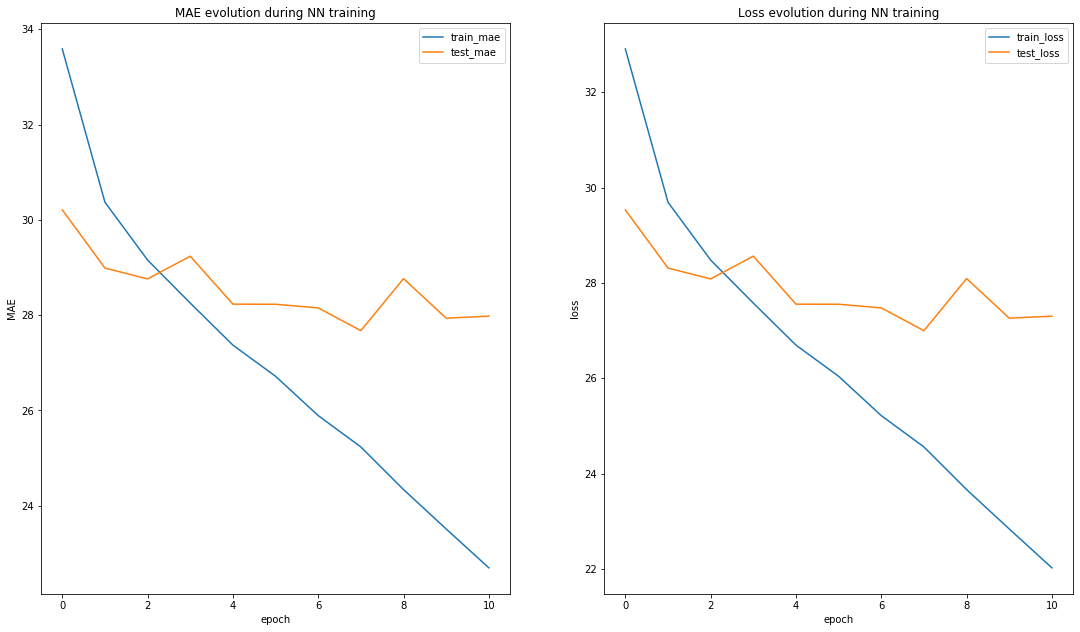

In [154]:
show_history(story)

The graphs above proves that the early stopping condition works successfully to prevent the overfitting behavior of the model. When the test set scores stop improving, the model chooses the best epoch and returns it as a best model.

## 5. Conclusions

AirBnB data is analysed in detail and several models are built in order to predict daily rental prices of houses. The analysis of different models showed that either textual data does not improve the predictive performance of the model for this particular dataset or the power of the textual data was not fully utilized with this modelling approach. 

A better idea for modelling might be feeding the outputs of textual LSTMs as inputs to ensemble learners. This might be a better approach seeing the high performance of ensemble learners on the non-text data in the beginning. However, it is outside of the scope of this project due to time limitations.

The task itself is a good example of how a real world dataset looks like including several data such as tabular, text and image. Although image data was not included in this project, another way to improve the performance might be using convolutional neural networks incorporating the additional image data. 